<a href="https://colab.research.google.com/github/leejunho12316/HonGongMachine/blob/main/AICE_Chapter_11_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#환경설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_termination = pd.read_csv('bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('bidet_w_disp_voc_test.csv')

In [3]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


#termination 데이터

1.   id : 중복 없는 ID
2.   status : Y/N
3. ★ new_date : int형 날짜 - str로 바꾼 후 strptime 해서 timedelta 계산가능
4.   bidet_cnt, w_disp_cnt - 계약 수

5. cust_cd : 10001, 10005 두 가지
6. sex_cd : M,F,_ 3가지

7. w_disp_yn, bidet_yn - 가입 여부
8. comb_prod_yn, bidet_comb_yn, w_disp_comb_yn - 결합 상품 가입 여부, 결합 여부

11.npay : 미납여부 YN
12. 3m_avg_bill_amt : 3개월 평균 청구 금액
13. 3m_bidet_avg_amt, 3m_w_disp_avg_amt : 각각의 3개월 평균 금액
(3m_avg_bill_amt != 3m_bidet_avg_amt + 3m_w_disp_avg_amt)

★★고유의 뜻을 해석해야 하는 열★★
9. trmn_eperd_cd : RXX 아니면 _, 0
10. trmn_why_cd : 1XXXX 아니면 _
14. engt_rperd_cd : RXX, PXX 아니면 _, 0, |


#VOC 데이터

1. id : 중복 없는 고유값
2. voc_type_cd, voc_type_nm : 연결되어 있는 voc 타입 값.
3. voc_cnt : 1개월간 voc 발생한 개수
4. day_cnt : 1개월간 voc 발생한 일수

#결합 상품 관련 column

In [4]:
#(bidet_comb_yn == y) + (w_disp_comb_yn == y) - (둘 다 y) = comb_prod_yn 인지

comb_y = train_termination['comb_prod_yn'].value_counts().loc['Y']
bc_y = train_termination['bidet_comb_yn'].value_counts().loc['Y']
dp_y = train_termination['w_disp_comb_yn'].value_counts().loc['Y']
bc_dp_y = train_termination[(train_termination['bidet_comb_yn'] == 'Y') & (train_termination['w_disp_comb_yn'] == 'Y')].shape[0]
res = bc_y + dp_y - bc_dp_y

print('comb_prod_yn == y : ', comb_y)
print('bc_y + dp_y - bc_dp_y : ', res)
print(comb_y - res, "만큼의 차이는 어디서 오는가?")

train_termination[(train_termination['comb_prod_yn'] == 'Y')][['bidet_comb_yn','w_disp_comb_yn']].value_counts()

comb_prod_yn == y :  41462
bc_y + dp_y - bc_dp_y :  41439
23 만큼의 차이는 어디서 오는가?


,,count
bidet_comb_yn,w_disp_comb_yn,
Y,Y,30560
N,Y,8364
Y,N,2515
N,N,23


In [5]:
#comb_prod_yn 값이 y인데 bidet_comb, disp comb 둘 다 n인 사람 : 23")
#결합상품을 가입했는데 가입을 안 한게 어떻게 가능하지 않음.

drop_index = train_termination[(train_termination['comb_prod_yn'] == 'Y') &
 (train_termination['bidet_comb_yn'] == 'N') & (train_termination['w_disp_comb_yn'] == 'N')].index
train_termination.drop(drop_index, inplace=True)

drop_index = test_termination[(test_termination['comb_prod_yn'] == 'Y') &
 (test_termination['bidet_comb_yn'] == 'N') & (test_termination['w_disp_comb_yn'] == 'N')].index
test_termination.drop(drop_index, inplace=True)

In [6]:
#정리 확인
train_termination[(train_termination['comb_prod_yn'] == 'Y')][['bidet_comb_yn','w_disp_comb_yn']].value_counts()

,,count
bidet_comb_yn,w_disp_comb_yn,
Y,Y,30560
N,Y,8364
Y,N,2515


#데이터 합치기

In [7]:
train_voc_cnt = train_voc.pivot_table(index = 'id', columns='voc_type_nm', values='voc_cnt', aggfunc='sum', fill_value=0)
train_day_cnt = train_voc.pivot_table(index = 'id', columns ='voc_type_nm', values='day_cnt', aggfunc='sum', fill_value=0)
test_voc_cnt = test_voc.pivot_table(index = 'id', columns ='voc_type_nm', values='voc_cnt', aggfunc='sum', fill_value=0)
test_day_cnt = test_voc.pivot_table(index = 'id', columns = 'voc_type_nm', values='day_cnt', aggfunc='sum', fill_value=0)

In [8]:
print("검증")
print(train_voc['voc_cnt'].sum(), train_voc_cnt.sum().sum())
print(train_voc['day_cnt'].sum(), train_day_cnt.sum().sum())
print(test_voc['voc_cnt'].sum(), test_voc_cnt.sum().sum())
print(test_voc['day_cnt'].sum(), test_day_cnt.sum().sum())

검증
90752 90752
82858 82858
8469 8469
7702 7702


In [9]:
for col in train_voc_cnt.columns:
  train_voc_cnt.rename(columns = {col : 'voc_cnt' + col}, inplace=True)
  train_day_cnt.rename(columns = {col : 'day_cnt' + col}, inplace=True)
for col in test_voc_cnt.columns:
  test_voc_cnt.rename(columns = {col : 'voc_cnt' + col}, inplace=True)
  test_day_cnt.rename(columns = {col : 'day_cnt' + col}, inplace=True)

In [10]:
#train,test columns 차이 : train에 대리점 문의 하나 더 이씀
(train_voc_cnt.columns), (test_voc_cnt.columns)

(Index(['voc_cntAS', 'voc_cnt가입', 'voc_cnt개통', 'voc_cnt대리점문의', 'voc_cnt변경/조회',
        'voc_cnt업무협조', 'voc_cnt이용', 'voc_cnt정보보호/언론보도', 'voc_cnt채널',
        'voc_cnt청구 수/미납', 'voc_cnt품질', 'voc_cnt해지', 'voc_cnt혜택'],
       dtype='object', name='voc_type_nm'),
 Index(['voc_cntAS', 'voc_cnt가입', 'voc_cnt개통', 'voc_cnt변경/조회', 'voc_cnt업무협조',
        'voc_cnt이용', 'voc_cnt정보보호/언론보도', 'voc_cnt채널', 'voc_cnt청구 수/미납',
        'voc_cnt품질', 'voc_cnt해지', 'voc_cnt혜택'],
       dtype='object', name='voc_type_nm'))

In [11]:
#1. train_termination, train_voc_cnt, train_day_cnt 합치기
train_termination.index = train_termination['id']
test_termination.index = test_termination['id']
train_termination.head(5)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
id,,,,,,,,,,,,,,,,,,,,,
E1000001,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
E1000002,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
E1000003,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
E1000004,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
E1000005,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [12]:
train_data = pd.concat([train_termination, train_voc_cnt, train_day_cnt], axis=1).reset_index(drop=True)
test_data = pd.concat([test_termination, test_voc_cnt, test_day_cnt], axis=1).reset_index(drop=True)

In [13]:
train_data.head(3)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt대리점문의,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택
0,E1000001,Y,20170421.0,1.0,0.0,10001.0,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,0,0
1,E1000002,N,20131203.0,2.0,0.0,10001.0,M,N,Y,N,...,0,0,0,0,0,0,0,0,1,0
2,E1000003,N,20170731.0,1.0,1.0,10001.0,M,Y,N,Y,...,0,0,1,0,0,0,0,0,0,0


In [14]:
test_data.head(3)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt개통,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택
0,E1055001,Y,20141111.0,4.0,1.0,10001.0,M,Y,Y,Y,...,0,0,0,0,0,0,0,1,0,0
1,E1055002,Y,20141120.0,2.0,0.0,10001.0,M,N,Y,Y,...,0,0,2,1,0,0,1,0,0,0
2,E1055003,N,20140818.0,1.0,0.0,10001.0,M,N,Y,N,...,0,0,1,0,0,0,0,0,0,0


In [15]:
#칼럼 맞추기
drop_columns = [col for col in train_data.columns if col not in test_data.columns]
train_data.drop(drop_columns, axis=1, inplace=True)
print(drop_columns)

['voc_cnt대리점문의', 'day_cnt대리점문의']


In [16]:
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

#결측치

In [17]:
train_termination.shape, train_data.shape

((54977, 22), (55000, 46))

In [18]:
train_termination

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
id,,,,,,,,,,,,,,,,,,,,,
E1000001,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
E1000002,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
E1000003,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
E1000004,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
E1000005,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,E1054996,N,20050916,0,1.0,10001,M,Y,N,Y,...,_,_,_,_,Y,127844.001,0,44800,P32,_
E1054997,E1054997,Y,20130117,0,1.0,10001,F,Y,N,Y,...,R37,_,_,10291,N,99000.000,0,48400,P01,_
E1054998,E1054998,Y,20190709,4,1.0,10001,F,N,Y,N,...,_,_,_,_,N,77882.001,14759,0,_,R18


In [19]:
#말도안되는 값 23개 없애고 생긴 null 행 지우기
train_data.drop(train_data.tail(23).index, inplace=True)
test_data.drop(test_data.tail(1).index, inplace=True)

In [20]:
#train_data : w_disp_cnt에 10개
print(train_data.isnull().sum().sum(), test_data.isnull().sum().sum())
train_data[train_data['w_disp_cnt'].isnull()]

10 0


,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt개통,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택
50,E1000051,Y,20200515.0,0.0,NaN,10001.0,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416.0,0.0,NaN,10001.0,F,Y,Y,Y,...,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022.0,1.0,NaN,10001.0,M,N,Y,N,...,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210.0,2.0,NaN,10001.0,F,N,Y,N,...,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028.0,1.0,NaN,10001.0,M,N,Y,N,...,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515.0,3.0,NaN,10001.0,M,Y,Y,Y,...,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716.0,1.0,NaN,10001.0,F,Y,Y,Y,...,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209.0,5.0,NaN,10001.0,M,Y,Y,Y,...,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023.0,2.0,NaN,10001.0,F,N,Y,Y,...,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927.0,1.0,NaN,10001.0,M,Y,Y,Y,...,0,0,1,0,0,0,0,0,0,0


median : 1.0
mean :  0.7374424654792876
mode 최빈값 :  0    1.0
Name: w_disp_cnt, dtype: float64


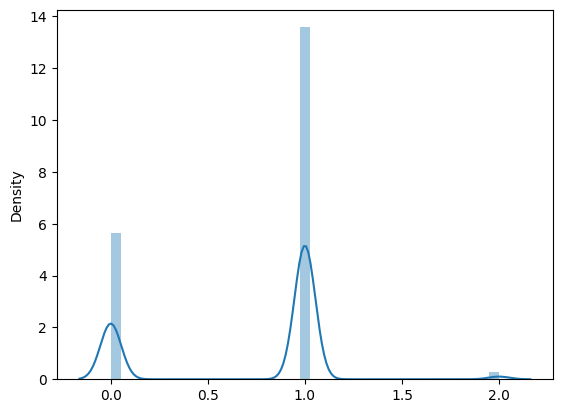

In [21]:
print("median :", train_data['w_disp_cnt'].median())
print("mean : ", train_data['w_disp_cnt'].mean())
print("mode 최빈값 : ", train_data['w_disp_cnt'].mode())

plt.plot()
sns.distplot(x=train_data[train_data['w_disp_cnt'] < 2.5]['w_disp_cnt'])
plt.show()

In [22]:
train_data.fillna(train_data['w_disp_cnt'].median(), inplace=True)
train_data.isnull().sum().sum()

np.int64(0)

#데이터 유형 변경

In [23]:
#데이터 합치며 float 된거 int로 바꾸기
train_data[['new_date', 'bidet_cnt', 'w_disp_cnt', 'cust_cd']] = train_data[['new_date', 'bidet_cnt', 'w_disp_cnt', 'cust_cd']].astype('int')
test_data[['new_date', 'bidet_cnt', 'w_disp_cnt', 'cust_cd']] = test_data[['new_date', 'bidet_cnt', 'w_disp_cnt', 'cust_cd']].astype('int')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54977 entries, 0 to 54976
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54977 non-null  object 
 1   status                54977 non-null  object 
 2   new_date              54977 non-null  int64  
 3   bidet_cnt             54977 non-null  int64  
 4   w_disp_cnt            54977 non-null  int64  
 5   cust_cd               54977 non-null  int64  
 6   sex_cd                54977 non-null  object 
 7   w_disp_yn             54977 non-null  object 
 8   bidet_yn              54977 non-null  object 
 9   comb_prod_yn          54977 non-null  object 
 10  bidet_comb_yn         54977 non-null  object 
 11  w_disp_comb_yn        54977 non-null  object 
 12  bidet_trmn_eperd_cd   54977 non-null  object 
 13  w_disp_trmn_eperd_cd  54977 non-null  object 
 14  w_disp_trmn_why_cd    54977 non-null  object 
 15  bidet_trmn_why_cd  

In [24]:
#new_date float64->datetime
#cust_cd float64->object
def str2time(x):
  t = datetime.strptime(str(x), '%Y%m%d')
  return t

train_data['new_date'] = train_data['new_date'].apply(lambda x : str2time(x))
test_data['new_date'] = test_data['new_date'].apply(lambda x : str2time(x))

In [25]:
train_data.head(3)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt개통,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택
0,E1000001,Y,2017-04-21,1,0,10001,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,0,0
1,E1000002,N,2013-12-03,2,0,10001,M,N,Y,N,...,0,0,0,0,0,0,0,0,1,0
2,E1000003,N,2017-07-31,1,1,10001,M,Y,N,Y,...,0,0,1,0,0,0,0,0,0,0


#파생 변수 추가하기

In [26]:
#@title newdate 최신 맞추기
#train_data는 8/31 데이터 추출, test_data는 9/30 데이터 추출
train_data['new_date'].max(), test_data['new_date'].max()

(Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-30 00:00:00'))

In [27]:
train_data['new_date'] = (datetime(2020,8,31) - train_data['new_date']).dt.days
test_data['new_date'] = (datetime(2020,9,30) - test_data['new_date']).dt.days

In [28]:
#@title trmn_eperd_cd
"""
0 : 해지 경과 기간이 당월 내인 경우.
RXX : 해지 후 경과 기간이 XX인 경우.
  최소값 : 01
  최대값 : 37
_ : 해지 안함.
"""
train_data['bidet_trmn_eperd_cd'].value_counts().index.sort_values()

Index(['0', 'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09',
       'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19',
       'R20', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R27', 'R28', 'R29',
       'R30', 'R31', 'R32', 'R33', 'R34', 'R35', 'R36', 'R37', '_'],
      dtype='object', name='bidet_trmn_eperd_cd')

In [29]:
def Rcd2int(x):
  if x == '0':
    return 0
  elif x == '_':
    return 38
  elif x[0] == 'R':
    return int(x[1:3])

for col in ['bidet_trmn_eperd_cd','w_disp_trmn_eperd_cd']:
  new_col = col.replace('_trmn_eperd_cd', '_teperd_cd')
  train_data[new_col] = train_data[col].apply(lambda x : Rcd2int(x))
  test_data[new_col] = test_data[col].apply(lambda x : Rcd2int(x))

In [30]:
train_data

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt업무협조,day_cnt이용,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택,bidet_teperd_cd,w_disp_teperd_cd
0,E1000001,Y,1228,1,0,10001,F,Y,Y,Y,...,0,0,0,0,1,0,0,0,38,38
1,E1000002,N,2463,2,0,10001,M,N,Y,N,...,0,0,0,0,0,0,1,0,38,38
2,E1000003,N,1127,1,1,10001,M,Y,N,Y,...,1,0,0,0,0,0,0,0,38,38
3,E1000004,Y,3988,4,1,10001,F,Y,Y,Y,...,0,0,0,0,0,1,0,0,38,38
4,E1000005,N,1745,1,1,10001,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,38,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54972,E1054996,N,5463,0,1,10001,M,Y,N,Y,...,0,0,0,0,0,1,0,0,38,38
54973,E1054997,Y,2783,0,1,10001,F,Y,N,Y,...,0,0,0,0,0,0,1,0,37,38
54974,E1054998,Y,419,4,1,10001,F,N,Y,N,...,1,0,0,0,0,0,0,0,38,38
54975,E1054999,Y,385,3,1,10001,M,N,Y,N,...,0,0,0,0,1,0,1,0,38,38


In [31]:
#@title _engt_rperd_cd
'''
약정 잔여 기간 코드 engagement remaning period code
0 : 약정 만료 당월. ->0
_ : 무약정. -> 약정 만료 PXX의 최대값 37보다 큰 38
| : 해지. -> 38
RXX : 잔여 약정 기간 XX
PXX : 약정 만료 후 경과한 기간 XX
   약정 만료한게 더 중요하니 양수, 남은건 덜 중요하니 음수
'''
train_data['bidet_engt_rperd_cd'].value_counts().index.sort_values()

Index(['0', 'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'R01', 'R02',
       'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12',
       'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20', 'R21', 'R22',
       'R23', 'R24', 'R25', 'R26', 'R27', 'R28', 'R29', 'R30', 'R34', '_',
       '|'],
      dtype='object', name='bidet_engt_rperd_cd')

In [32]:
def RPcd2int(x):
  if x == '0':
    return 0
  elif x == '_' or x == '|':
    return 38
  elif x[0] == 'R':
    return -int(x[1:3])
  elif x[0] == 'P':
    return -int(x[1:3])

for col in ['bidet_engt_rperd_cd','w_disp_engt_rperd_cd']:
  new_col = col.replace('_engt_rperd_cd','_erperd')
  train_data[new_col] = train_data[col].apply(lambda x : RPcd2int(x))
  test_data[new_col] = test_data[col].apply(lambda x : RPcd2int(x))

In [33]:
train_data

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt정보보호/언론보도,day_cnt채널,day_cnt청구 수/미납,day_cnt품질,day_cnt해지,day_cnt혜택,bidet_teperd_cd,w_disp_teperd_cd,bidet_erperd,w_disp_erperd
0,E1000001,Y,1228,1,0,10001,F,Y,Y,Y,...,0,0,1,0,0,0,38,38,-12,-9
1,E1000002,N,2463,2,0,10001,M,N,Y,N,...,0,0,0,0,1,0,38,38,-6,38
2,E1000003,N,1127,1,1,10001,M,Y,N,Y,...,0,0,0,0,0,0,38,38,38,0
3,E1000004,Y,3988,4,1,10001,F,Y,Y,Y,...,0,0,0,1,0,0,38,38,-11,-36
4,E1000005,N,1745,1,1,10001,F,Y,Y,Y,...,0,0,0,0,1,0,38,38,-22,-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54972,E1054996,N,5463,0,1,10001,M,Y,N,Y,...,0,0,0,1,0,0,38,38,38,-32
54973,E1054997,Y,2783,0,1,10001,F,Y,N,Y,...,0,0,0,0,1,0,37,38,38,-1
54974,E1054998,Y,419,4,1,10001,F,N,Y,N,...,0,0,0,0,0,0,38,38,-18,38
54975,E1054999,Y,385,3,1,10001,M,N,Y,N,...,0,0,1,0,1,0,38,38,-19,38


#칼럼 삭제하기

In [34]:
del_cols=[]

del_cols.append('id') #id 값
del_cols.append('cust_cd') #10001, 10005 값

In [35]:
#@title 수치형 데이터 중 0 비율 90% 넘는곳
num_cols = train_data.select_dtypes([int, float]).columns
obj_cols = train_data.select_dtypes('O').columns
len(num_cols) + len(obj_cols)

50

In [36]:
for col in num_cols:
  ratio = (train_data[col]==0).sum() / len(train_data)

  if ratio > 0.9:
    print("%s : %f" %(col, ratio))
    del_cols.append(col)

voc_cntAS : 0.965131
voc_cnt개통 : 0.983848
voc_cnt정보보호/언론보도 : 0.993706
voc_cnt채널 : 0.934318
voc_cnt품질 : 0.900031
voc_cnt혜택 : 0.967223
day_cntAS : 0.965131
day_cnt개통 : 0.983848
day_cnt정보보호/언론보도 : 0.993706
day_cnt채널 : 0.934318
day_cnt품질 : 0.900031
day_cnt혜택 : 0.967223


In [37]:
for col in obj_cols:
  ratio = train_data[col].value_counts().iloc[0] / len(train_data)

  if ratio > 0.9:
    print("%s : %f" %(col, ratio))
    del_cols.append(col)

bidet_trmn_eperd_cd : 0.926733
w_disp_trmn_eperd_cd : 0.937810
w_disp_trmn_why_cd : 0.942067
bidet_trmn_why_cd : 0.929425


In [38]:
del_cols += ['bidet_engt_rperd_cd', 'w_disp_engt_rperd_cd']

In [39]:
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)

#-------------------------------------------------------------------------------------------------------------------------------------------

#EDA와 시각화

In [40]:
#@title 이상치 처리
number = ['int64', 'float64']
num_cols = train_data.select_dtypes(number).columns
print(num_cols)

Index(['new_date', 'bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt',
       '3m_bidet_avg_amt', '3m_w_disp_avg_amt', 'voc_cnt가입', 'voc_cnt변경/조회',
       'voc_cnt업무협조', 'voc_cnt이용', 'voc_cnt청구 수/미납', 'voc_cnt해지', 'day_cnt가입',
       'day_cnt변경/조회', 'day_cnt업무협조', 'day_cnt이용', 'day_cnt청구 수/미납',
       'day_cnt해지', 'bidet_teperd_cd', 'w_disp_teperd_cd', 'bidet_erperd',
       'w_disp_erperd'],
      dtype='object')


In [41]:
outlier_cols = train_data.describe().loc['max'][train_data.describe().loc['max'] > 20].index.tolist()
print(outlier_cols)

['new_date', 'bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt', 'voc_cnt변경/조회', 'voc_cnt업무협조', 'bidet_teperd_cd', 'w_disp_teperd_cd', 'bidet_erperd', 'w_disp_erperd']


In [42]:
def replace_outlier(df, cols):
  for column in cols:
    q1, q3 = np.percentile(df[column], [25,75])
    iqr = q3-q1
    upperfence = q3 + iqr * 1.5

    df[column] = df[column].apply(lambda x : x if x <= upperfence else upperfence)

  return df

In [43]:
train_data.describe()

,new_date,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt가입,voc_cnt변경/조회,voc_cnt업무협조,voc_cnt이용,...,day_cnt가입,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt청구 수/미납,day_cnt해지,bidet_teperd_cd,w_disp_teperd_cd,bidet_erperd,w_disp_erperd
count,54977.000000,54977.000000,54977.000000,5.497700e+04,5.497700e+04,5.497700e+04,54977.000000,54977.000000,54977.000000,54977.000000,...,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.00000,54977.000000,54977.000000
mean,1858.099805,2.597413,0.737490,2.916035e+05,3.441577e+04,4.164504e+04,0.129909,0.214744,0.332430,0.123906,...,0.125889,0.201502,0.284192,0.117558,0.219765,0.272969,36.867617,36.91009,-2.882915,4.672208
std,1615.889381,66.492907,1.137241,8.498040e+05,3.833563e+04,3.965949e+05,0.366095,0.552746,0.886067,0.398583,...,0.348154,0.447997,0.580217,0.362426,0.464875,0.518758,5.710088,5.62842,22.216523,29.972722
min,0.000000,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-37.000000,-37.000000
25%,748.000000,1.000000,0.000000,1.102630e+05,1.132900e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-17.000000,-23.000000
50%,1357.000000,1.000000,1.000000,1.994810e+05,3.108200e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-10.000000,-2.000000
75%,2517.000000,2.000000,1.000000,3.363480e+05,4.804400e+04,4.792000e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-2.000000,38.000000
max,8396.000000,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,6.000000,59.000000,102.000000,14.000000,...,4.000000,11.000000,16.000000,11.000000,7.000000,6.000000,38.000000,38.00000,38.000000,38.000000


In [44]:
outlier_cols = train_data.describe().loc['max'][train_data.describe().loc['max'] > 20].index.tolist()
train_data_del_outlier = replace_outlier(train_data, outlier_cols)

In [45]:
train_data_del_outlier.describe()

,new_date,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt가입,voc_cnt변경/조회,voc_cnt업무협조,voc_cnt이용,...,day_cnt가입,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt청구 수/미납,day_cnt해지,bidet_teperd_cd,w_disp_teperd_cd,bidet_erperd,w_disp_erperd
count,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.0,54977.0,54977.000000,...,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.000000,54977.00000,54977.000000,54977.000000
mean,1785.990405,1.510677,0.726195,248935.797947,32823.351447,31167.313204,0.129909,0.0,0.0,0.123906,...,0.125889,0.201502,0.284192,0.117558,0.219765,0.272969,36.867617,36.91009,-6.508522,4.672208
std,1413.193100,1.174837,0.480945,182008.008609,25932.119480,34589.066646,0.366095,0.0,0.0,0.398583,...,0.348154,0.447997,0.580217,0.362426,0.464875,0.518758,5.710088,5.62842,15.729645,29.972722
min,0.000000,0.000000,0.000000,-11363.001000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-37.000000,-37.000000
25%,748.000000,1.000000,0.000000,110262.999000,11329.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-17.000000,-23.000000
50%,1357.000000,1.000000,1.000000,199481.001000,31082.000000,32660.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-10.000000,-2.000000
75%,2517.000000,2.000000,1.000000,336348.000000,48044.000000,47920.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.00000,-2.000000,38.000000
max,5170.500000,3.500000,2.500000,675475.501500,103116.500000,119800.000000,6.000000,0.0,0.0,14.000000,...,4.000000,11.000000,16.000000,11.000000,7.000000,6.000000,38.000000,38.00000,20.500000,38.000000


In [46]:
#@title 시각화

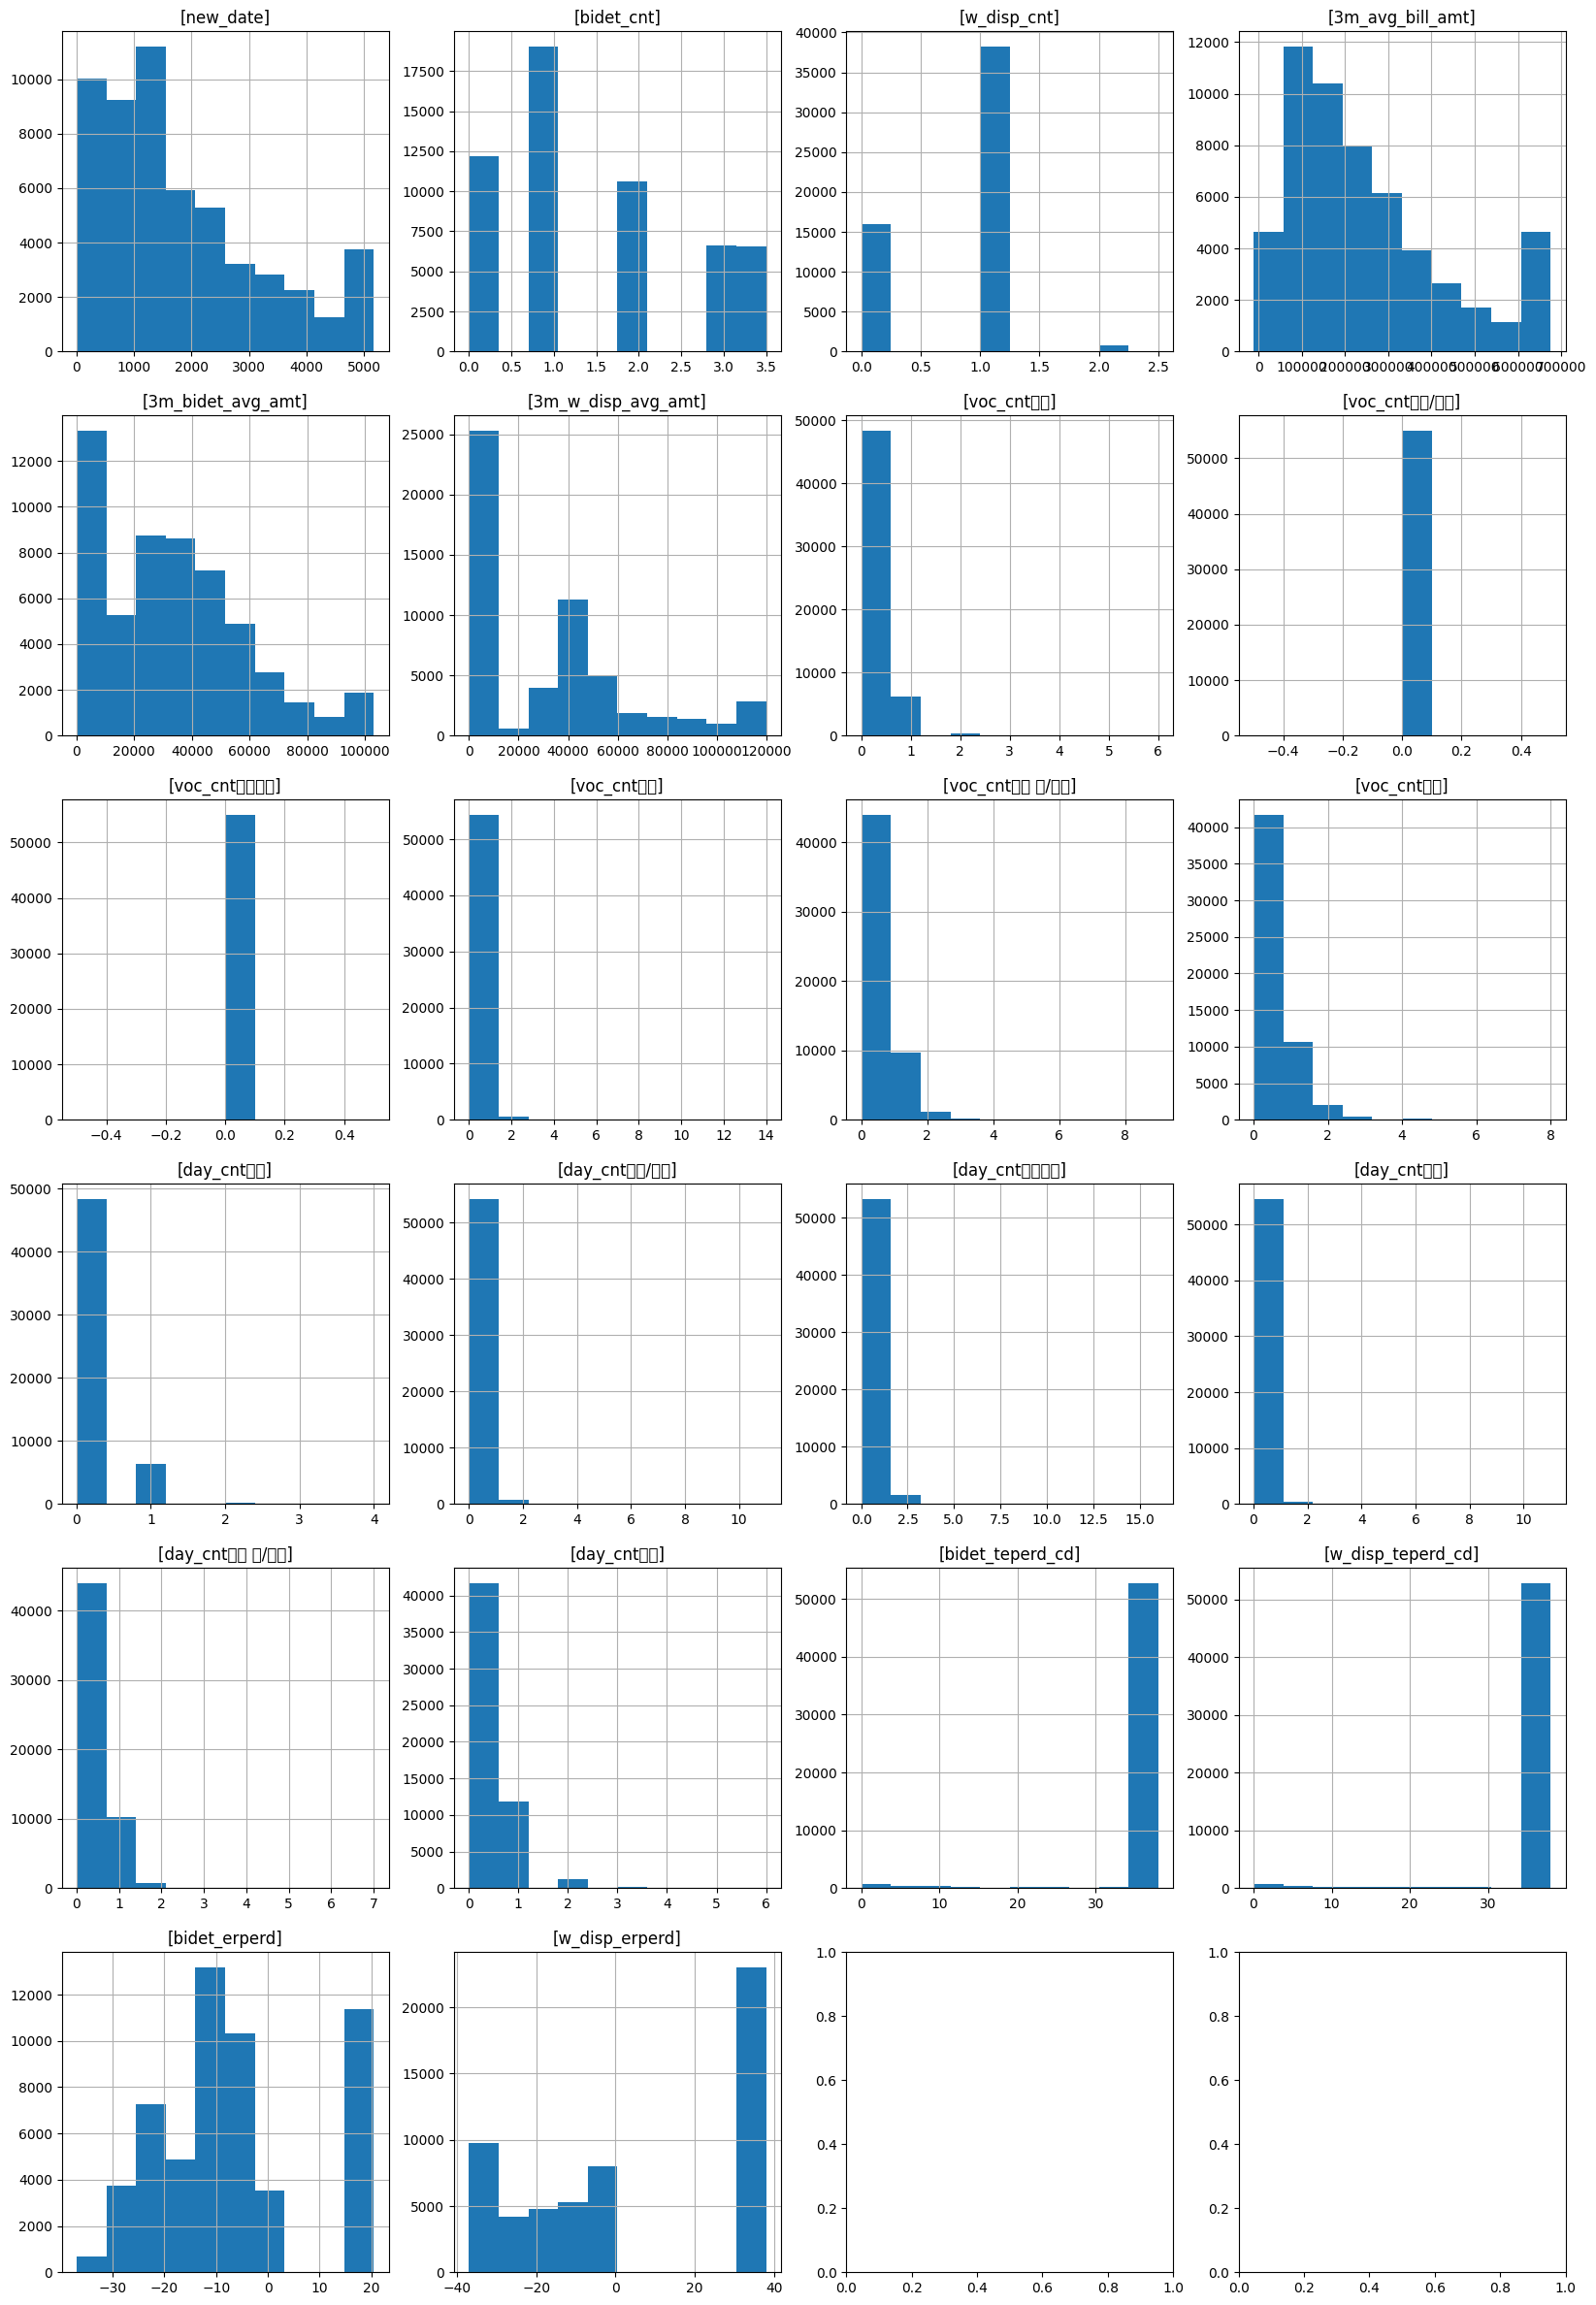

In [47]:
def make_histplot(df, col_names):

  total_num = len(col_names)
  col_num = 4
  row_num = math.ceil(total_num/col_num)
  graphsize=5

  plt.rcParams['figure.figsize'] = (col_num * graphsize, row_num * graphsize)
  fig, ax = plt.subplots(nrows = row_num, ncols = col_num)

  i=0
  for col in col_names:
    df[col].hist(ax = ax[int(i/col_num)][i%col_num])
    ax[int(i/col_num)][i%col_num].set_title('[' + col + ']')
    i+=1

  plt.show()

  plt.rcParams['figure.figsize'] = (7,7)

make_histplot(train_data, num_cols)

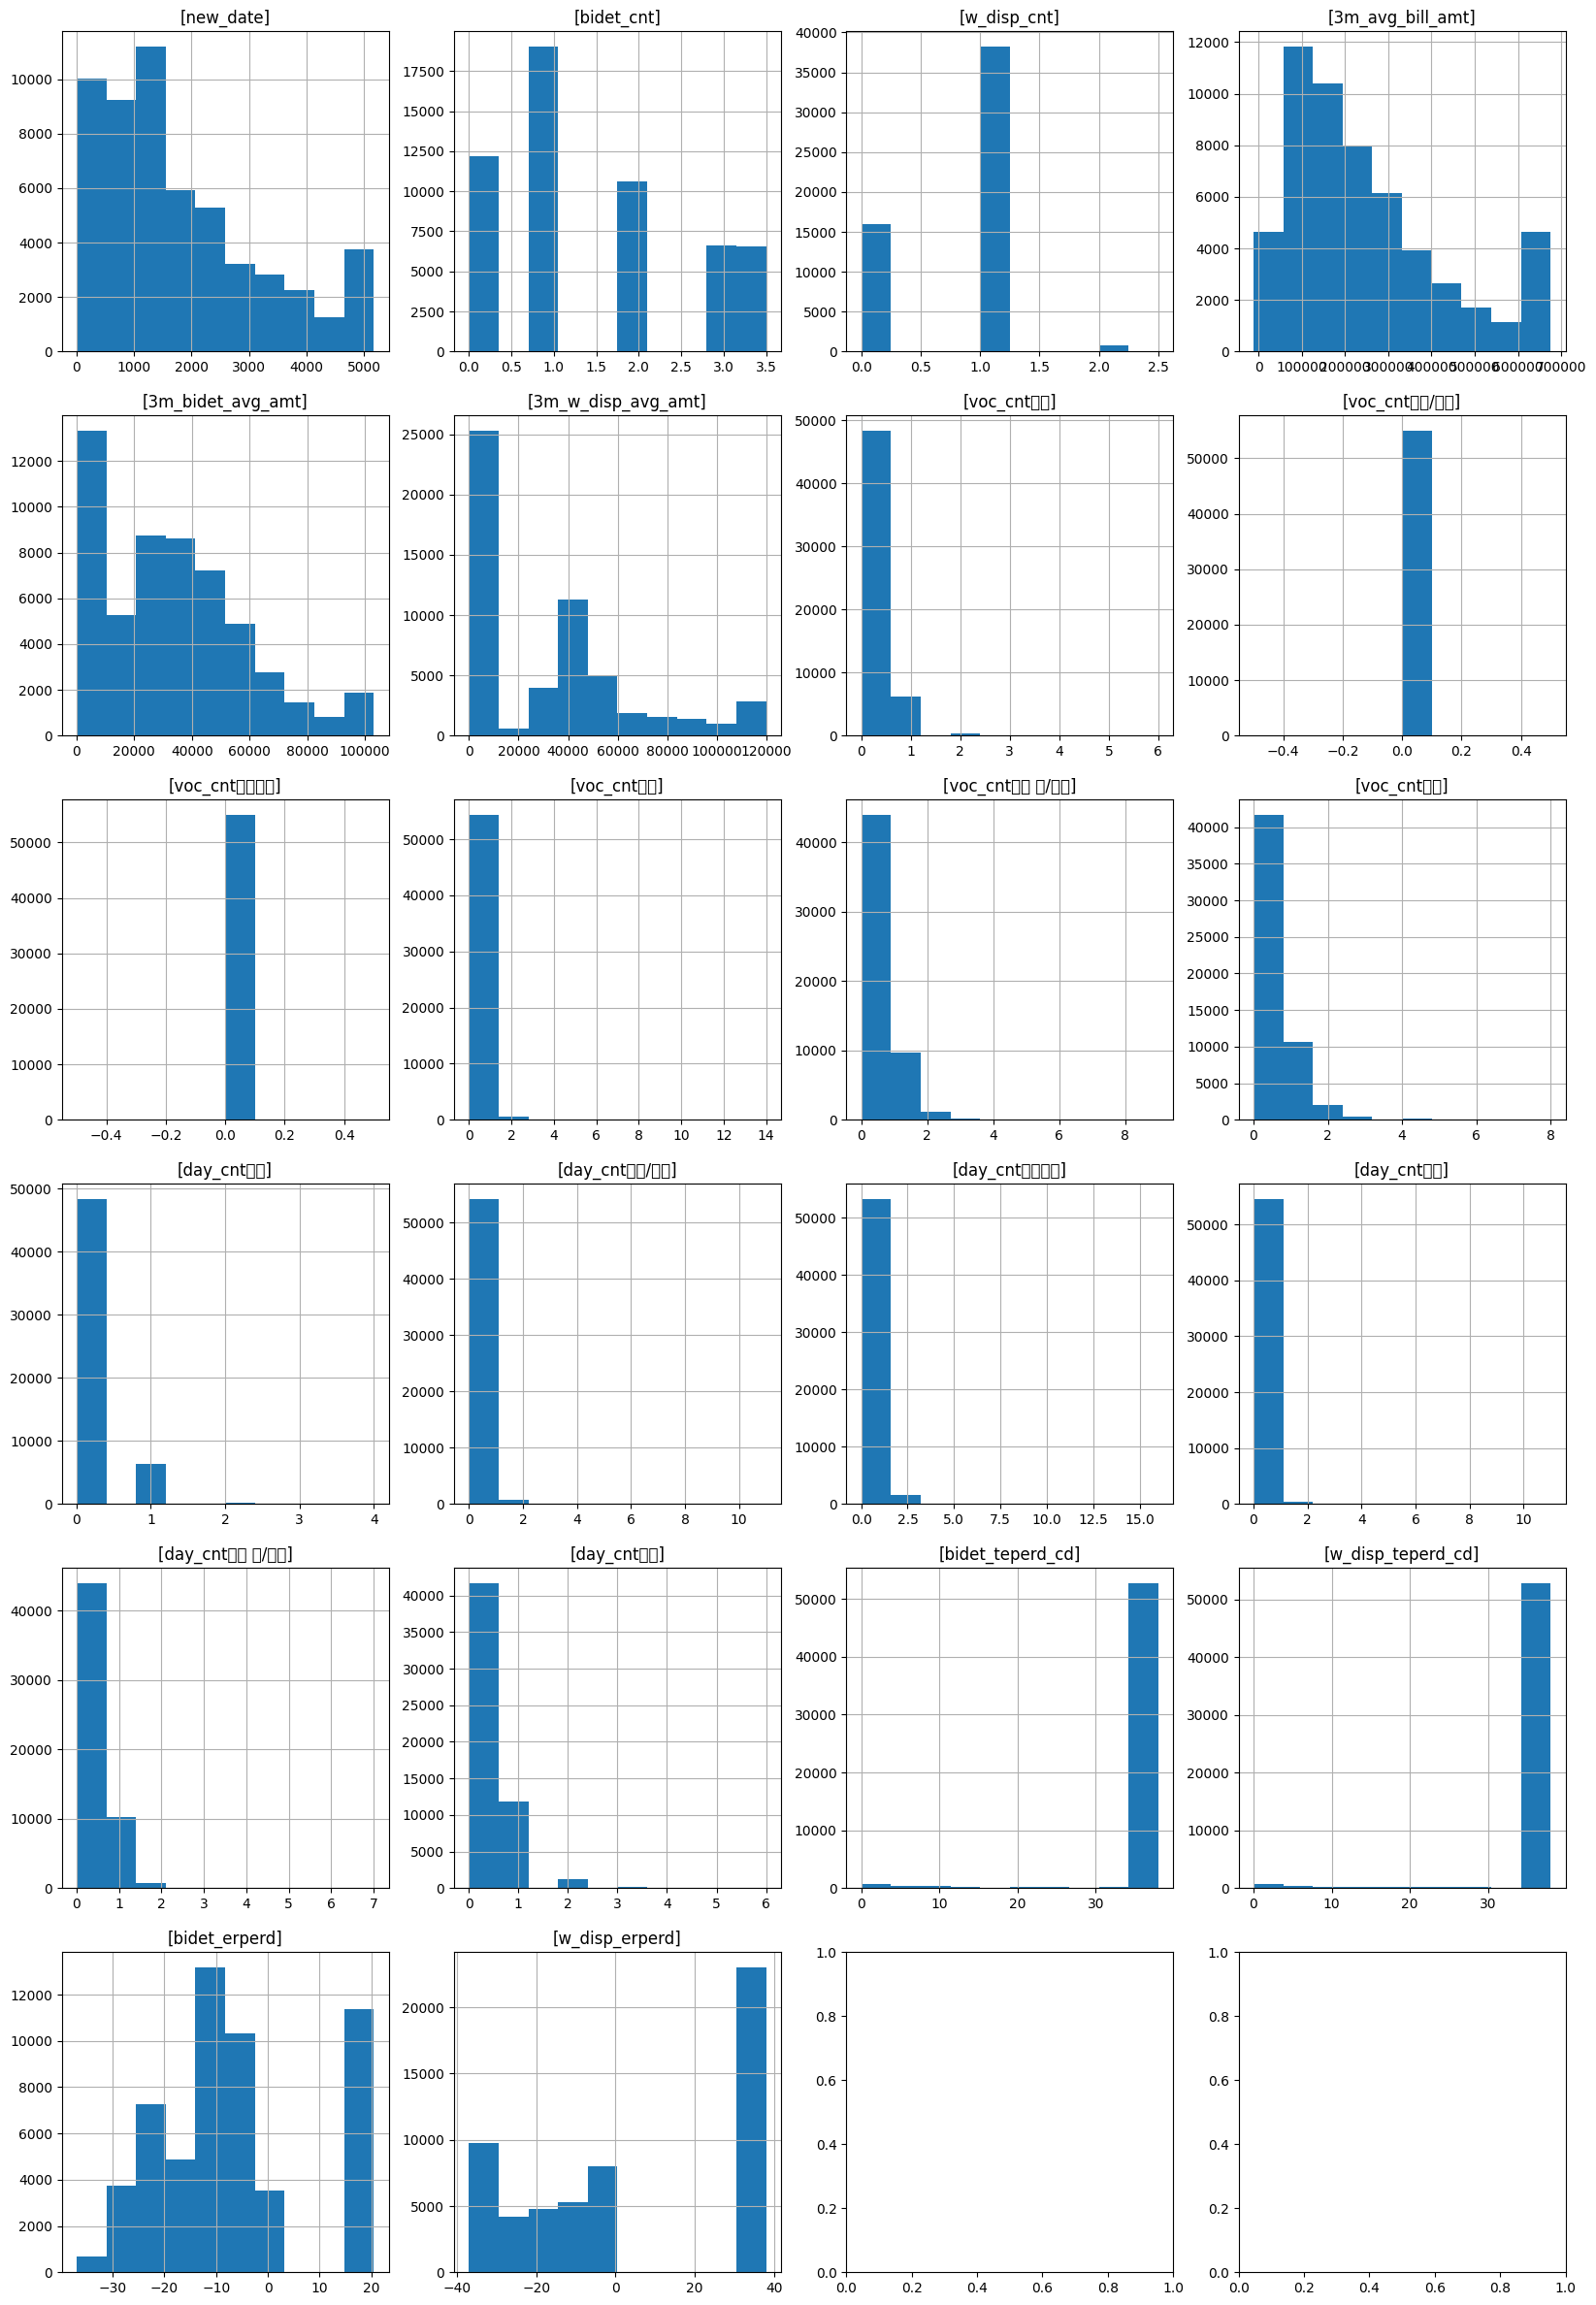

In [48]:
make_histplot(train_data_del_outlier, num_cols)

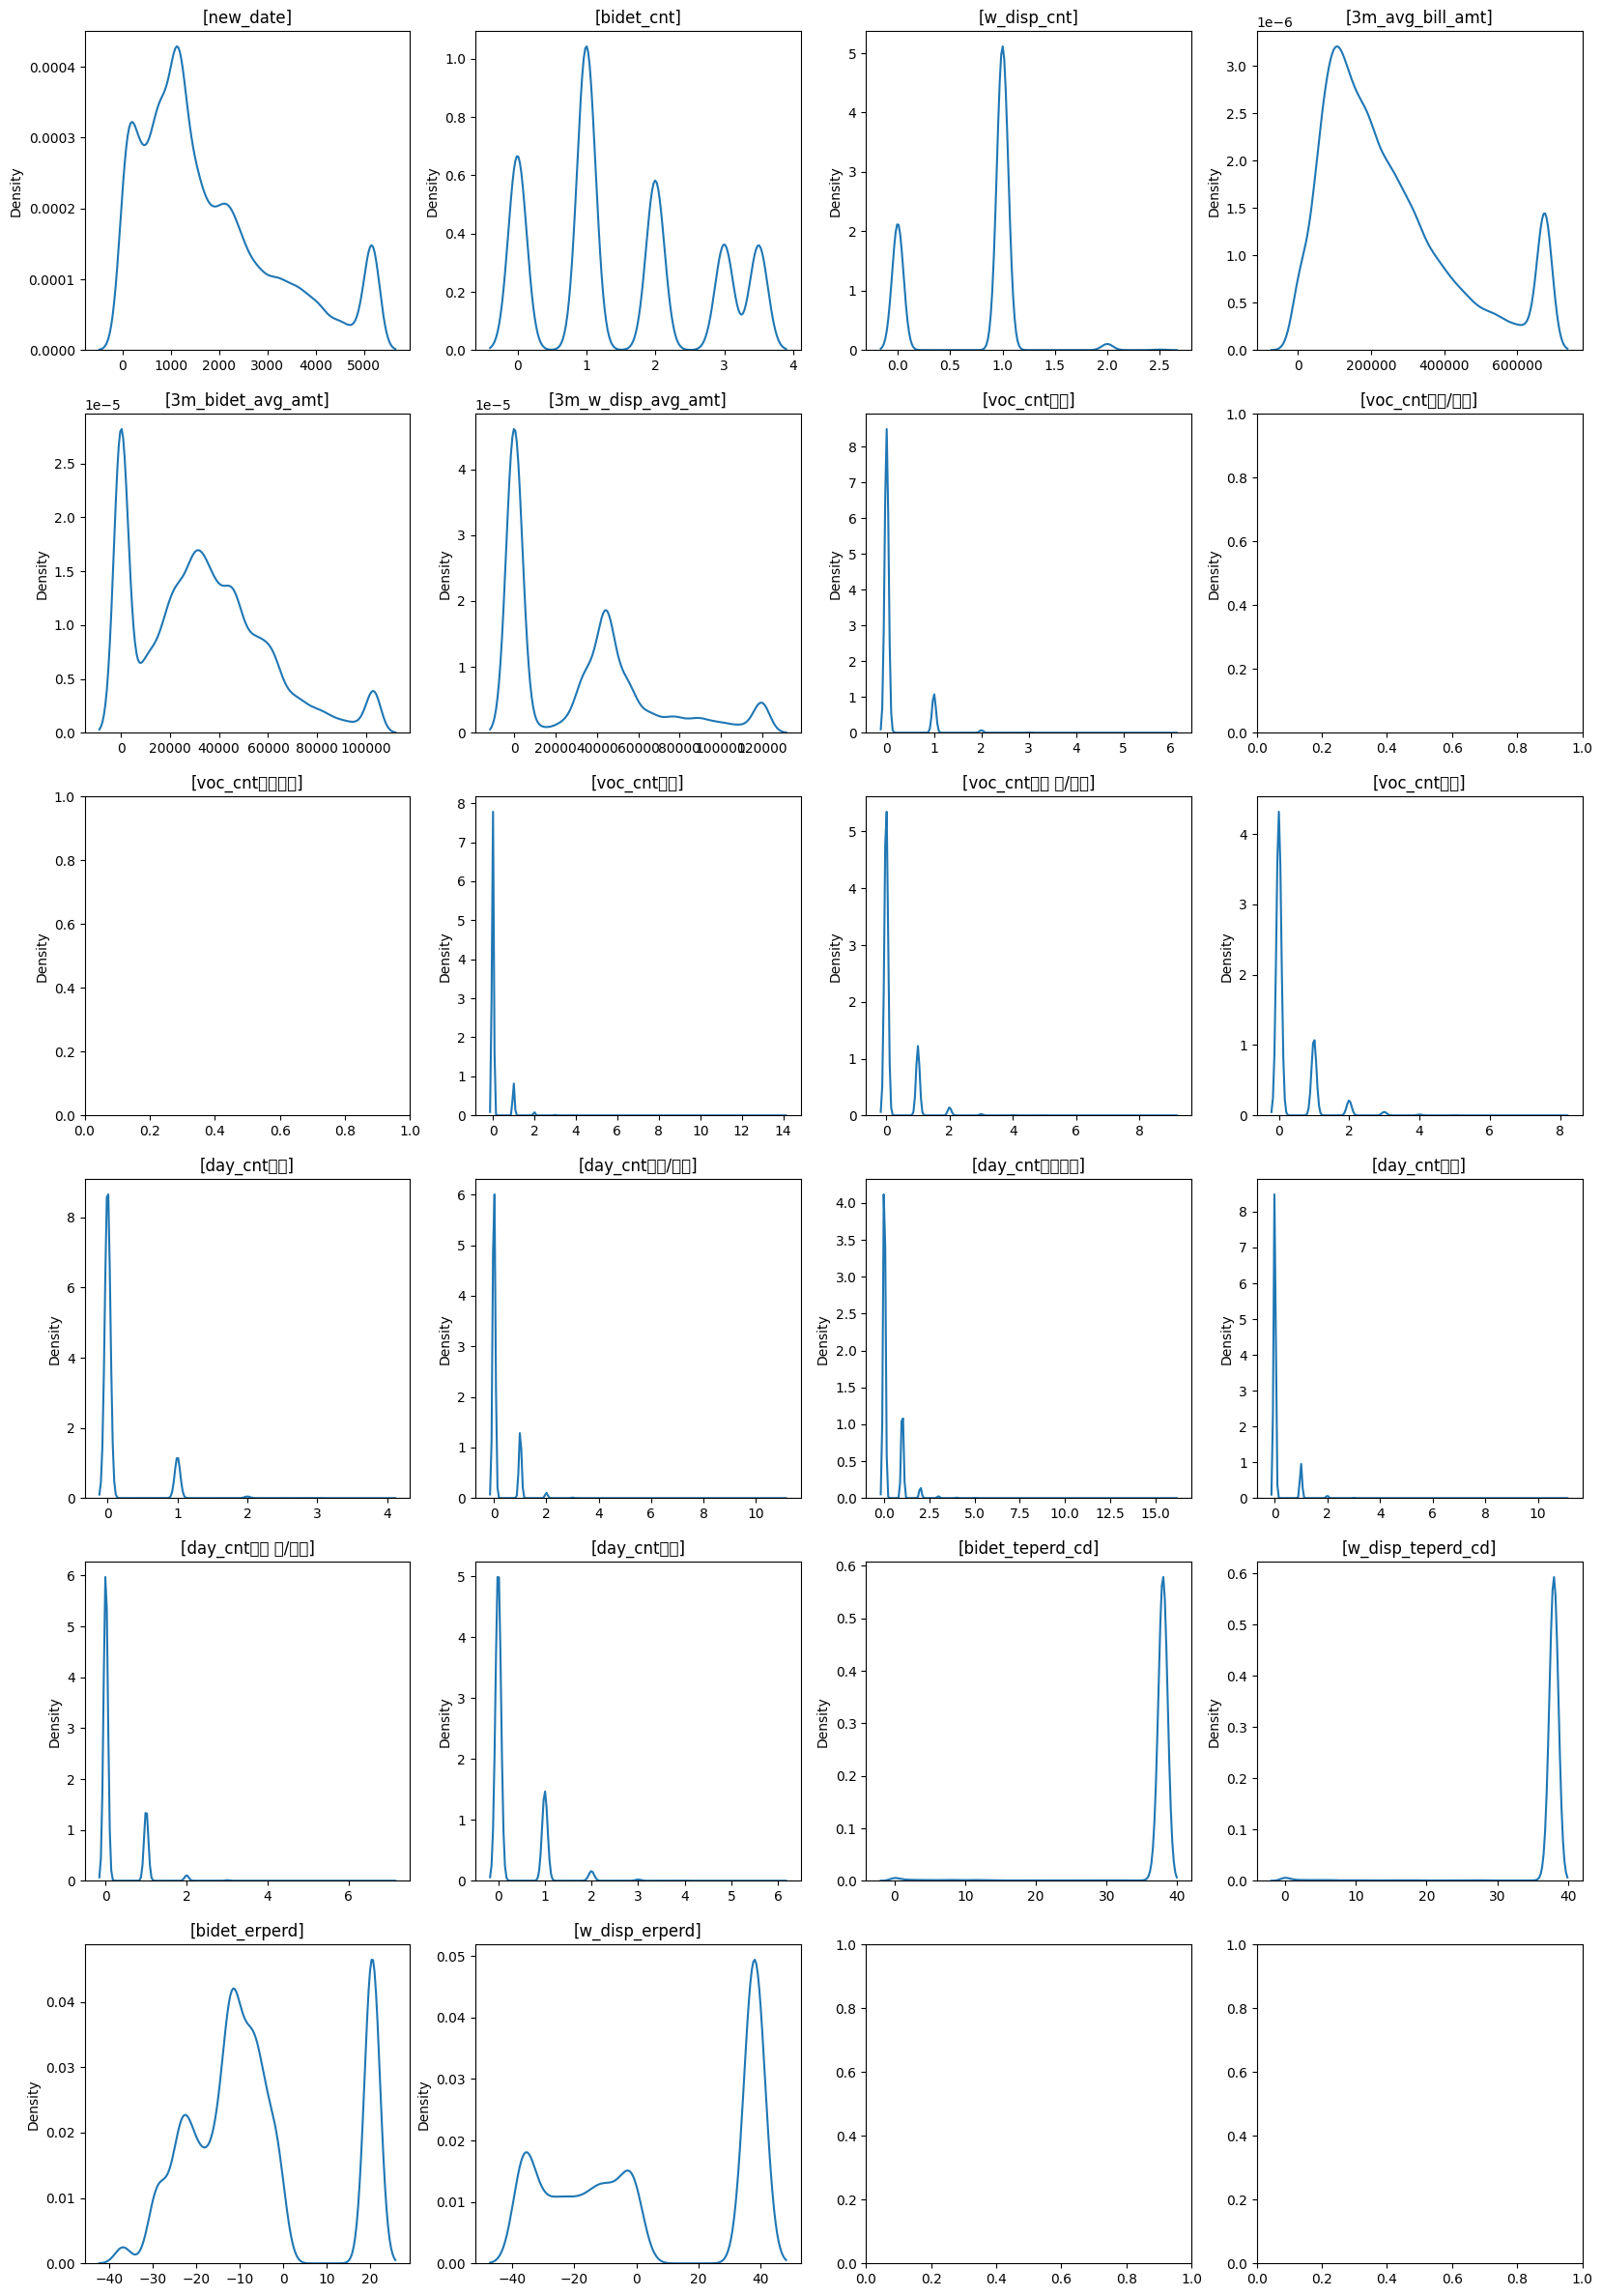

In [49]:
def make_kdeplot(df, col_names):
  total_cnt = len(col_names)
  col_cnt = 4
  row_cnt = math.ceil(total_cnt / col_cnt)

  graphsize = 5
  plt.rcParams['figure.figsize'] = (col_cnt * graphsize, row_cnt * graphsize)

  fig, ax = plt.subplots(nrows = row_cnt, ncols = col_cnt)

  i=0
  for col in col_names:
    sns.kdeplot(data=df[col], ax = ax[int(i/col_cnt)][i%col_cnt])
    ax[int(i/col_cnt)][i%col_cnt].set_title('[' + col + ']')
    ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
    i+=1

  plt.show()
  plt.rcParams['figure.figsize'] = (7, 7)


make_kdeplot(train_data_del_outlier, num_cols)

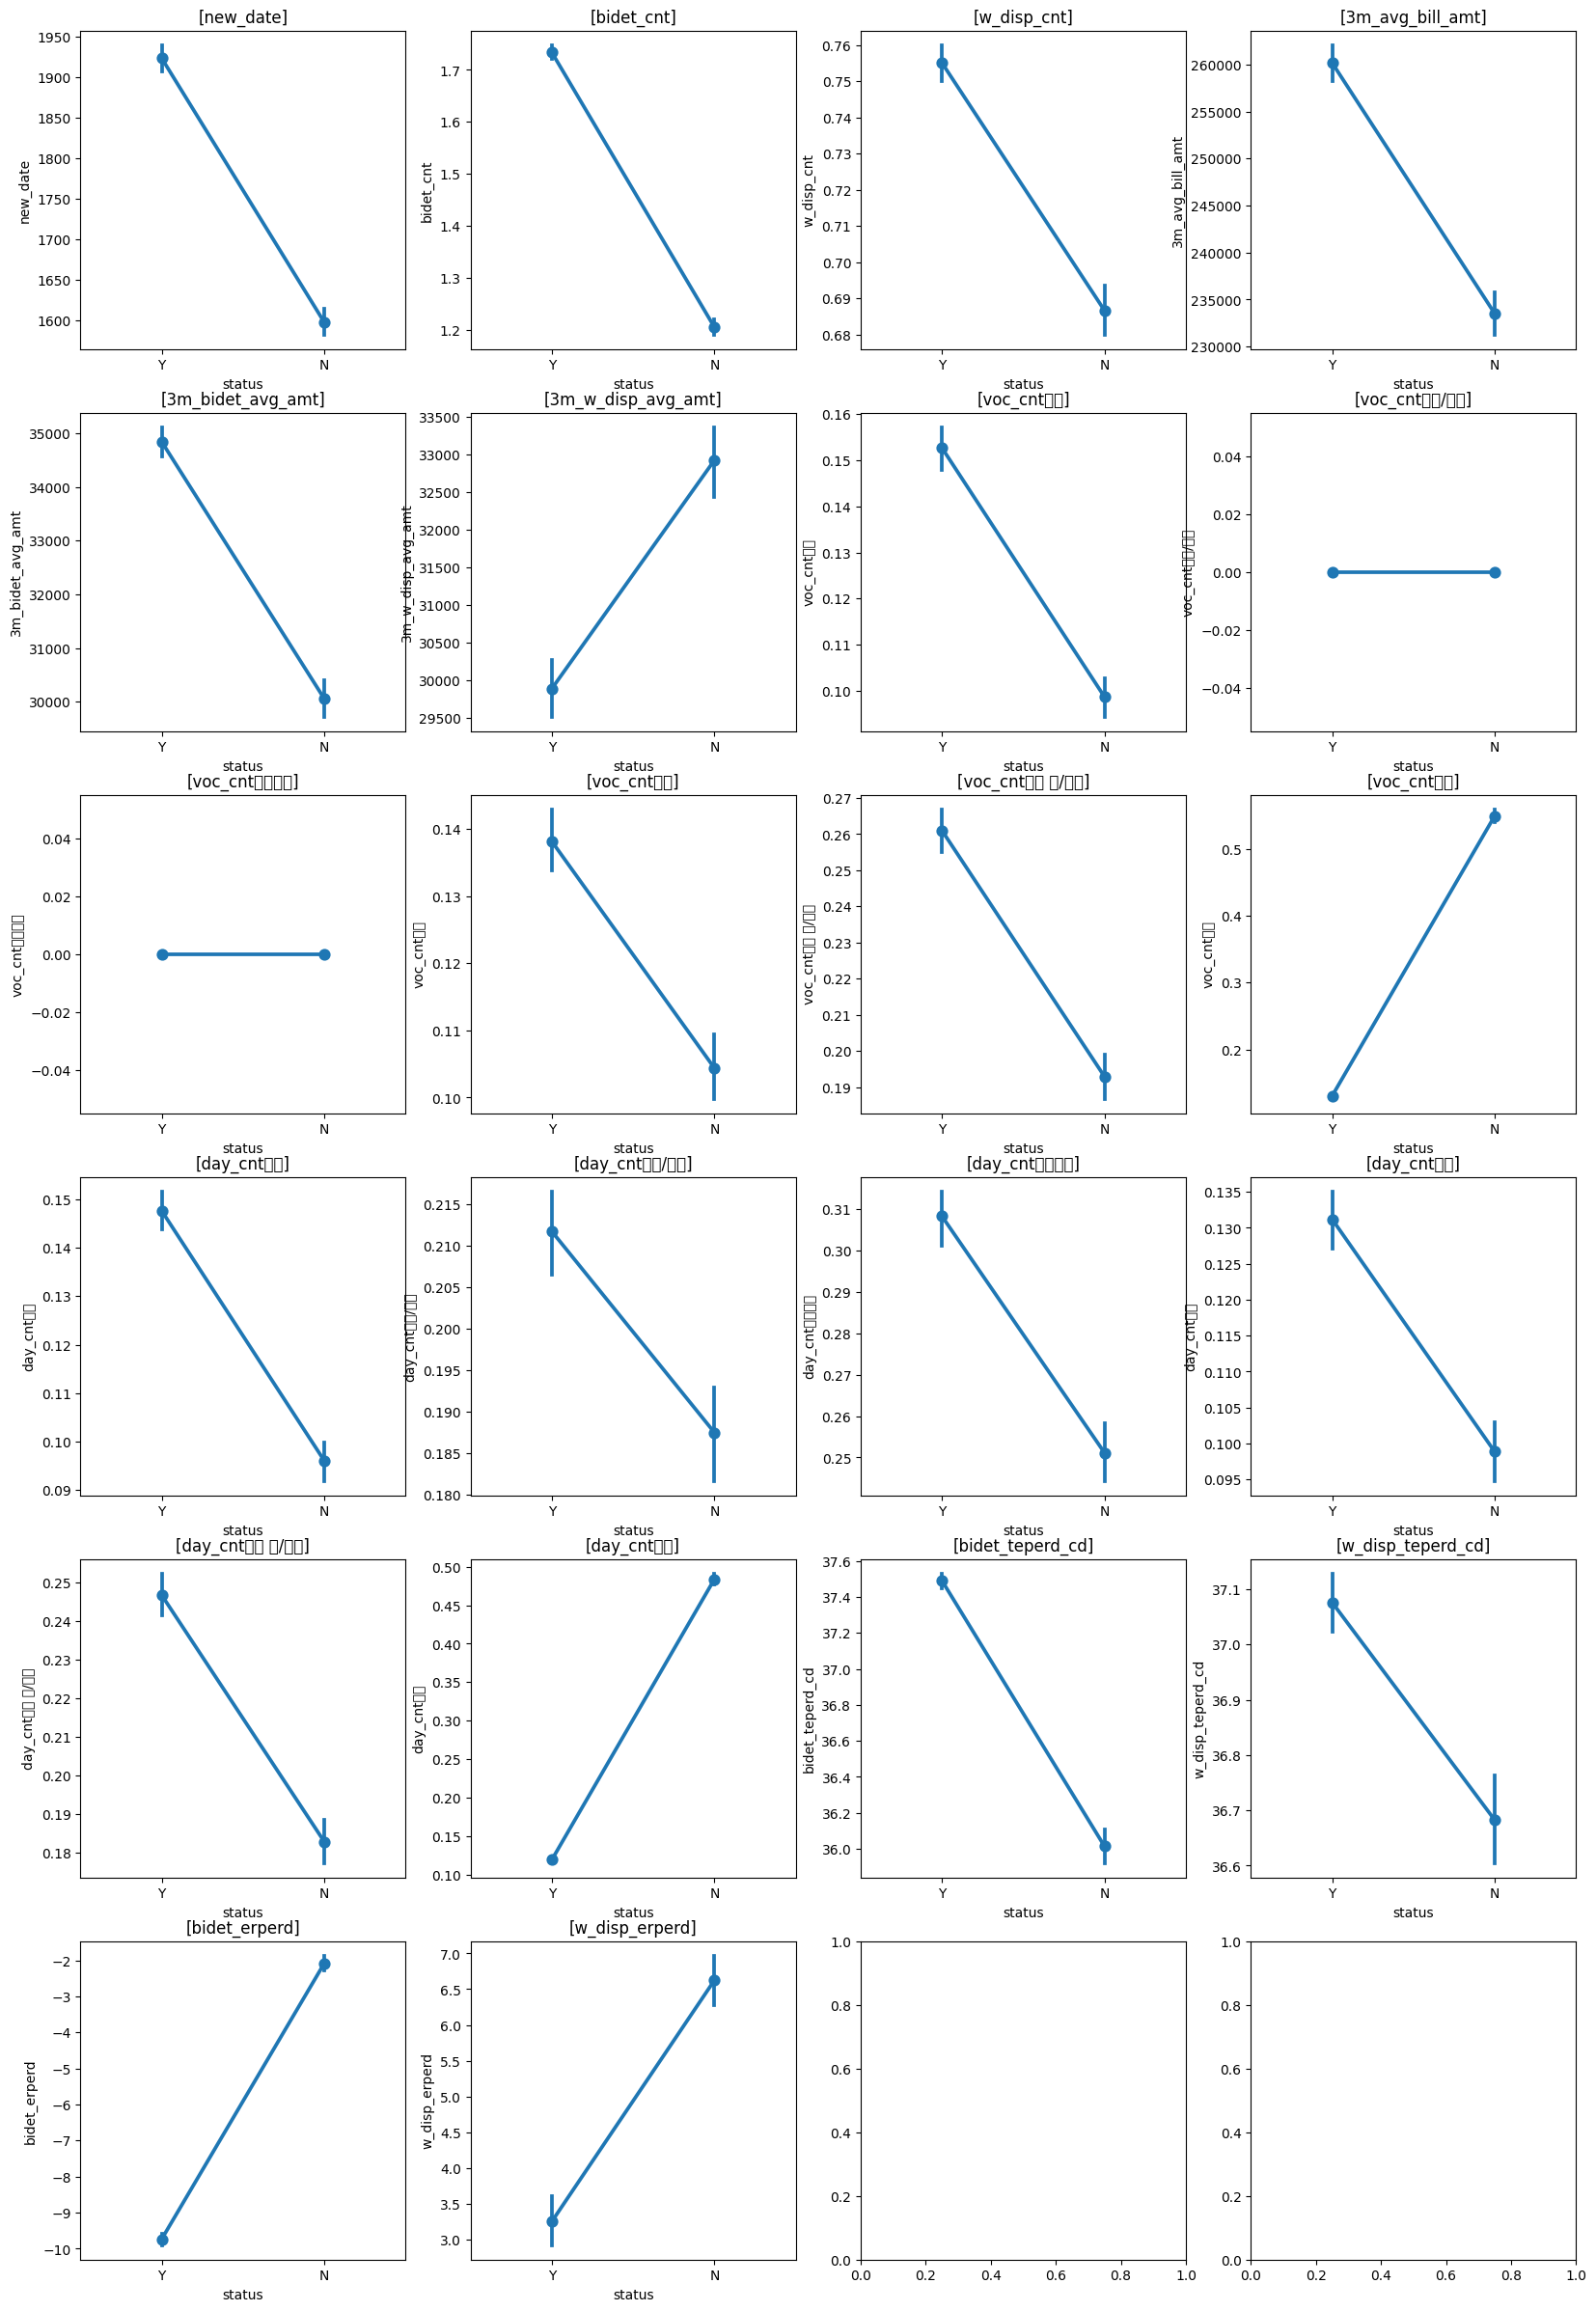

In [50]:
def make_pointplot(df, col_names, label):
  total_cnt = len(col_names)
  col_cnt = 4
  row_cnt = math.ceil(total_cnt/col_cnt)

  graphsize = 5
  plt.rcParams['figure.figsize'] = (col_cnt * graphsize, row_cnt  * graphsize)

  fig, ax = plt.subplots(nrows = row_cnt, ncols = col_cnt)
  i=0
  for col in col_names:
    sns.pointplot(data = df, x = label, y = col, ax = ax[int(i/col_cnt)][i%col_cnt])
    ax[int(i/col_cnt)][i%col_cnt].set_title('[' + col + ']')
    i+=1

  plt.show()

  plt.rcParams['figure.figsize'] = (7, 7)

make_pointplot(train_data_del_outlier, num_cols, 'status')

In [51]:
obj_cols = train_data.select_dtypes('O').columns
obj_cols

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

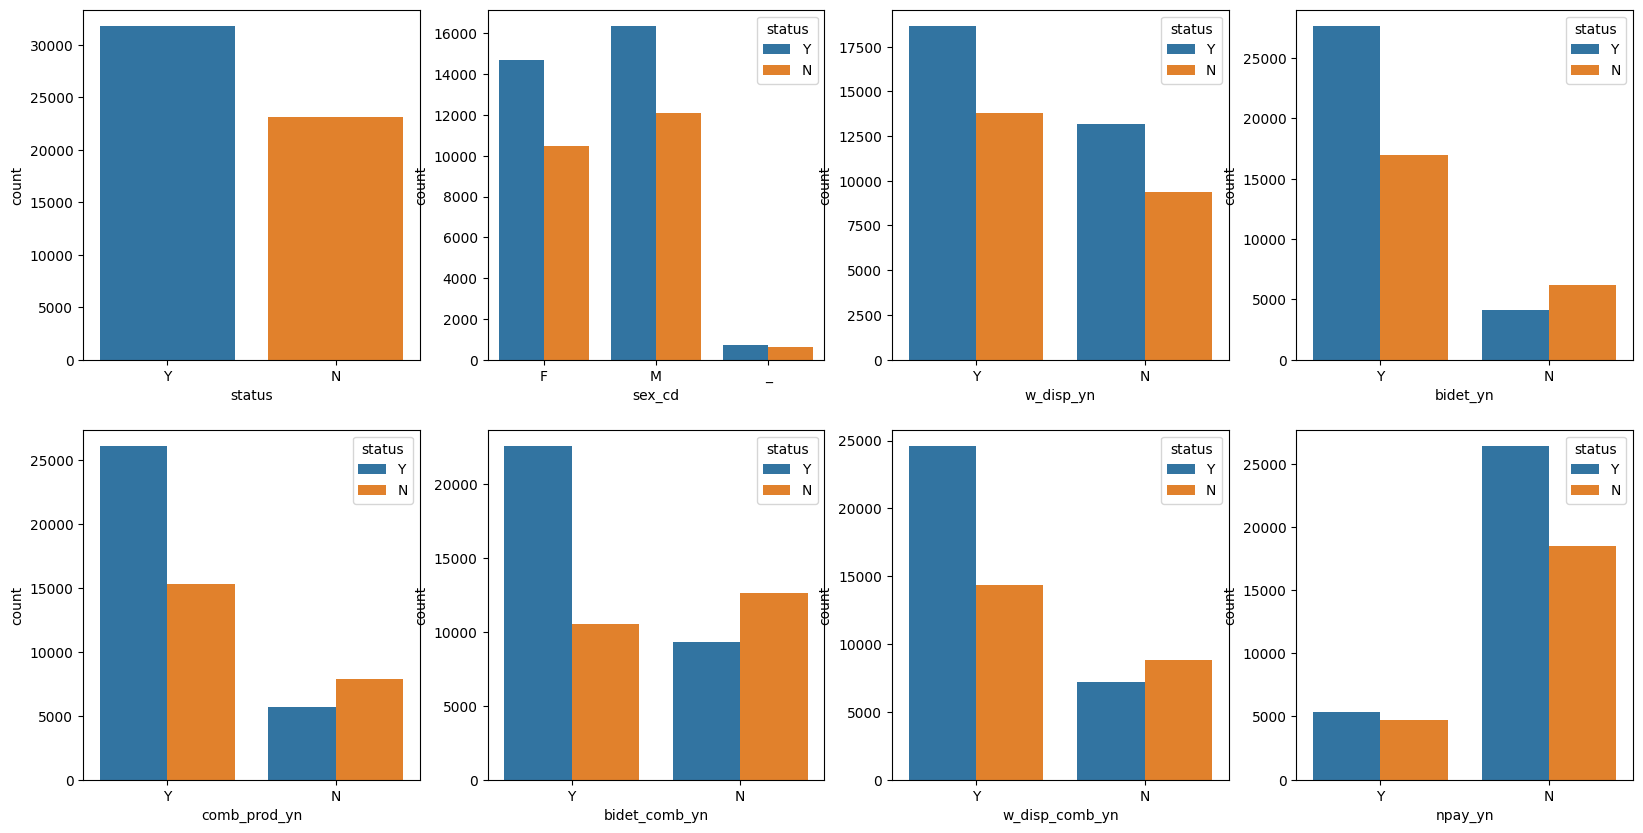

In [52]:
def make_countplot(df, obj_cols, label):
  total_cnt = len(obj_cols)
  col_cnt = 4
  row_cnt = math.ceil(total_cnt/col_cnt)

  graphsize = 5
  plt.rcParams['figure.figsize'] = (col_cnt * graphsize, row_cnt * graphsize)

  fig, ax = plt.subplots(nrows = row_cnt, ncols = col_cnt)
  i=0
  for col in obj_cols:
    sns.countplot(data = df, x = col, hue=label, ax = ax[int(i/col_cnt)][i%col_cnt])
    i+=1
  plt.show()

  plt.rcParams['figure.figsize'] = (7, 7)

make_countplot(train_data, obj_cols, 'status')

#AI 모델링을 위한 전처리

In [53]:
#@title 수치형 데이터 표준화-이상치-정규화
num_cols = train_data.select_dtypes(['int64','float64']).columns
num_cols

Index(['new_date', 'bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt',
       '3m_bidet_avg_amt', '3m_w_disp_avg_amt', 'voc_cnt가입', 'voc_cnt변경/조회',
       'voc_cnt업무협조', 'voc_cnt이용', 'voc_cnt청구 수/미납', 'voc_cnt해지', 'day_cnt가입',
       'day_cnt변경/조회', 'day_cnt업무협조', 'day_cnt이용', 'day_cnt청구 수/미납',
       'day_cnt해지', 'bidet_teperd_cd', 'w_disp_teperd_cd', 'bidet_erperd',
       'w_disp_erperd'],
      dtype='object')

In [54]:
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

In [55]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
train_data_scaled[num_cols] = standardScaler.fit_transform(train_data_scaled[num_cols])
test_data_scaled[num_cols] = standardScaler.transform(test_data_scaled[num_cols])

In [56]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
train_data_scaled[num_cols] = minMaxScaler.fit_transform(train_data_scaled[num_cols])
test_data_scaled[num_cols] = minMaxScaler.transform(test_data_scaled[num_cols])

In [57]:
train_data_scaled

,status,new_date,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,...,day_cnt가입,day_cnt변경/조회,day_cnt업무협조,day_cnt이용,day_cnt청구 수/미납,day_cnt해지,bidet_teperd_cd,w_disp_teperd_cd,bidet_erperd,w_disp_erperd
0,Y,0.237501,0.285714,0.0,F,Y,Y,Y,Y,Y,...,0.0,0.0,0.0000,0.0,0.142857,0.000000,1.000000,1.0,0.434783,0.373333
1,N,0.476356,0.571429,0.0,M,N,Y,N,N,N,...,0.0,0.0,0.0000,0.0,0.000000,0.166667,1.000000,1.0,0.539130,1.000000
2,N,0.217967,0.285714,0.4,M,Y,N,Y,Y,Y,...,0.0,0.0,0.0625,0.0,0.000000,0.000000,1.000000,1.0,1.000000,0.493333
3,Y,0.771299,1.000000,0.4,F,Y,Y,Y,Y,Y,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,1.000000,1.0,0.452174,0.013333
4,N,0.337492,0.285714,0.4,F,Y,Y,Y,Y,Y,...,0.0,0.0,0.0000,0.0,0.000000,0.166667,1.000000,1.0,0.260870,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54972,N,1.000000,0.000000,0.4,M,Y,N,Y,N,Y,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,1.000000,1.0,1.000000,0.066667
54973,Y,0.538246,0.000000,0.4,F,Y,N,Y,N,Y,...,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.973684,1.0,1.000000,0.480000
54974,Y,0.081037,1.000000,0.4,F,N,Y,N,N,N,...,0.0,0.0,0.0625,0.0,0.000000,0.000000,1.000000,1.0,0.330435,1.000000
54975,Y,0.074461,0.857143,0.4,M,N,Y,N,N,N,...,0.0,0.0,0.0000,0.0,0.142857,0.166667,1.000000,1.0,0.313043,1.000000


In [58]:
#@title 범주형 데이터 레이블 인코딩 - 원 핫 인코딩
le_columns = train_data_scaled.select_dtypes('O').columns
le_columns

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [59]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in le_columns:
  train_data_scaled[column] = le.fit_transform(train_data_scaled[column])

  print("column :", column)
  print("le classes : ", le.classes_)

  for label in np.unique(test_data_scaled[column]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)
      print('없는 label : ', label)

  test_data_scaled[column] = le.transform(test_data_scaled[column])


column : status
le classes :  ['N' 'Y']
column : sex_cd
le classes :  ['F' 'M' '_']
column : w_disp_yn
le classes :  ['N' 'Y']
column : bidet_yn
le classes :  ['N' 'Y']
column : comb_prod_yn
le classes :  ['N' 'Y']
column : bidet_comb_yn
le classes :  ['N' 'Y']
column : w_disp_comb_yn
le classes :  ['N' 'Y']
column : npay_yn
le classes :  ['N' 'Y']


In [60]:
#status N 0->1, Y 1->0
train_data_scaled['status'].apply(lambda x : 1 if x==0 else 0)
test_data_scaled['status'].apply(lambda x : 1 if x==0 else 0)

,status
0,0
1,0
2,1
3,0
4,0
...,...
4994,1
4995,0
4996,1
4997,1


In [61]:
#@title 레이블 종류 3개 넘는 칼럼 One-Hot Encoding
for col in le_columns:
  print(train_data_scaled[col].value_counts())

status
1    31793
0    23184
Name: count, dtype: int64
sex_cd
1    28476
0    25166
2     1335
Name: count, dtype: int64
w_disp_yn
1    32456
0    22521
Name: count, dtype: int64
bidet_yn
1    44637
0    10340
Name: count, dtype: int64
comb_prod_yn
1    41439
0    13538
Name: count, dtype: int64
bidet_comb_yn
1    33075
0    21902
Name: count, dtype: int64
w_disp_comb_yn
1    38924
0    16053
Name: count, dtype: int64
npay_yn
0    44903
1    10074
Name: count, dtype: int64


In [62]:
oh_columns = ['sex_cd']

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False, drop='if_binary')
train_onehot = enc.fit_transform(train_data_scaled[oh_columns])
test_onehot = enc.transform(test_data_scaled[oh_columns])

train_onehot_df = pd.DataFrame(train_onehot, columns = enc.get_feature_names_out(oh_columns))
test_onehot_df = pd.DataFrame(test_onehot, columns = enc.get_feature_names_out(oh_columns))

In [63]:
train_data_oh = pd.concat([train_data_scaled, train_onehot_df], axis=1)
test_data_oh = pd.concat([test_data_scaled, test_onehot_df], axis=1)

train_data_oh.drop(oh_columns, axis=1, inplace=True)
test_data_oh.drop(oh_columns, axis=1, inplace=True)

In [64]:
#@title 마지막 저장
train_data = train_data_oh
test_data = test_data_oh

#다중공선성 제거

<Axes: >

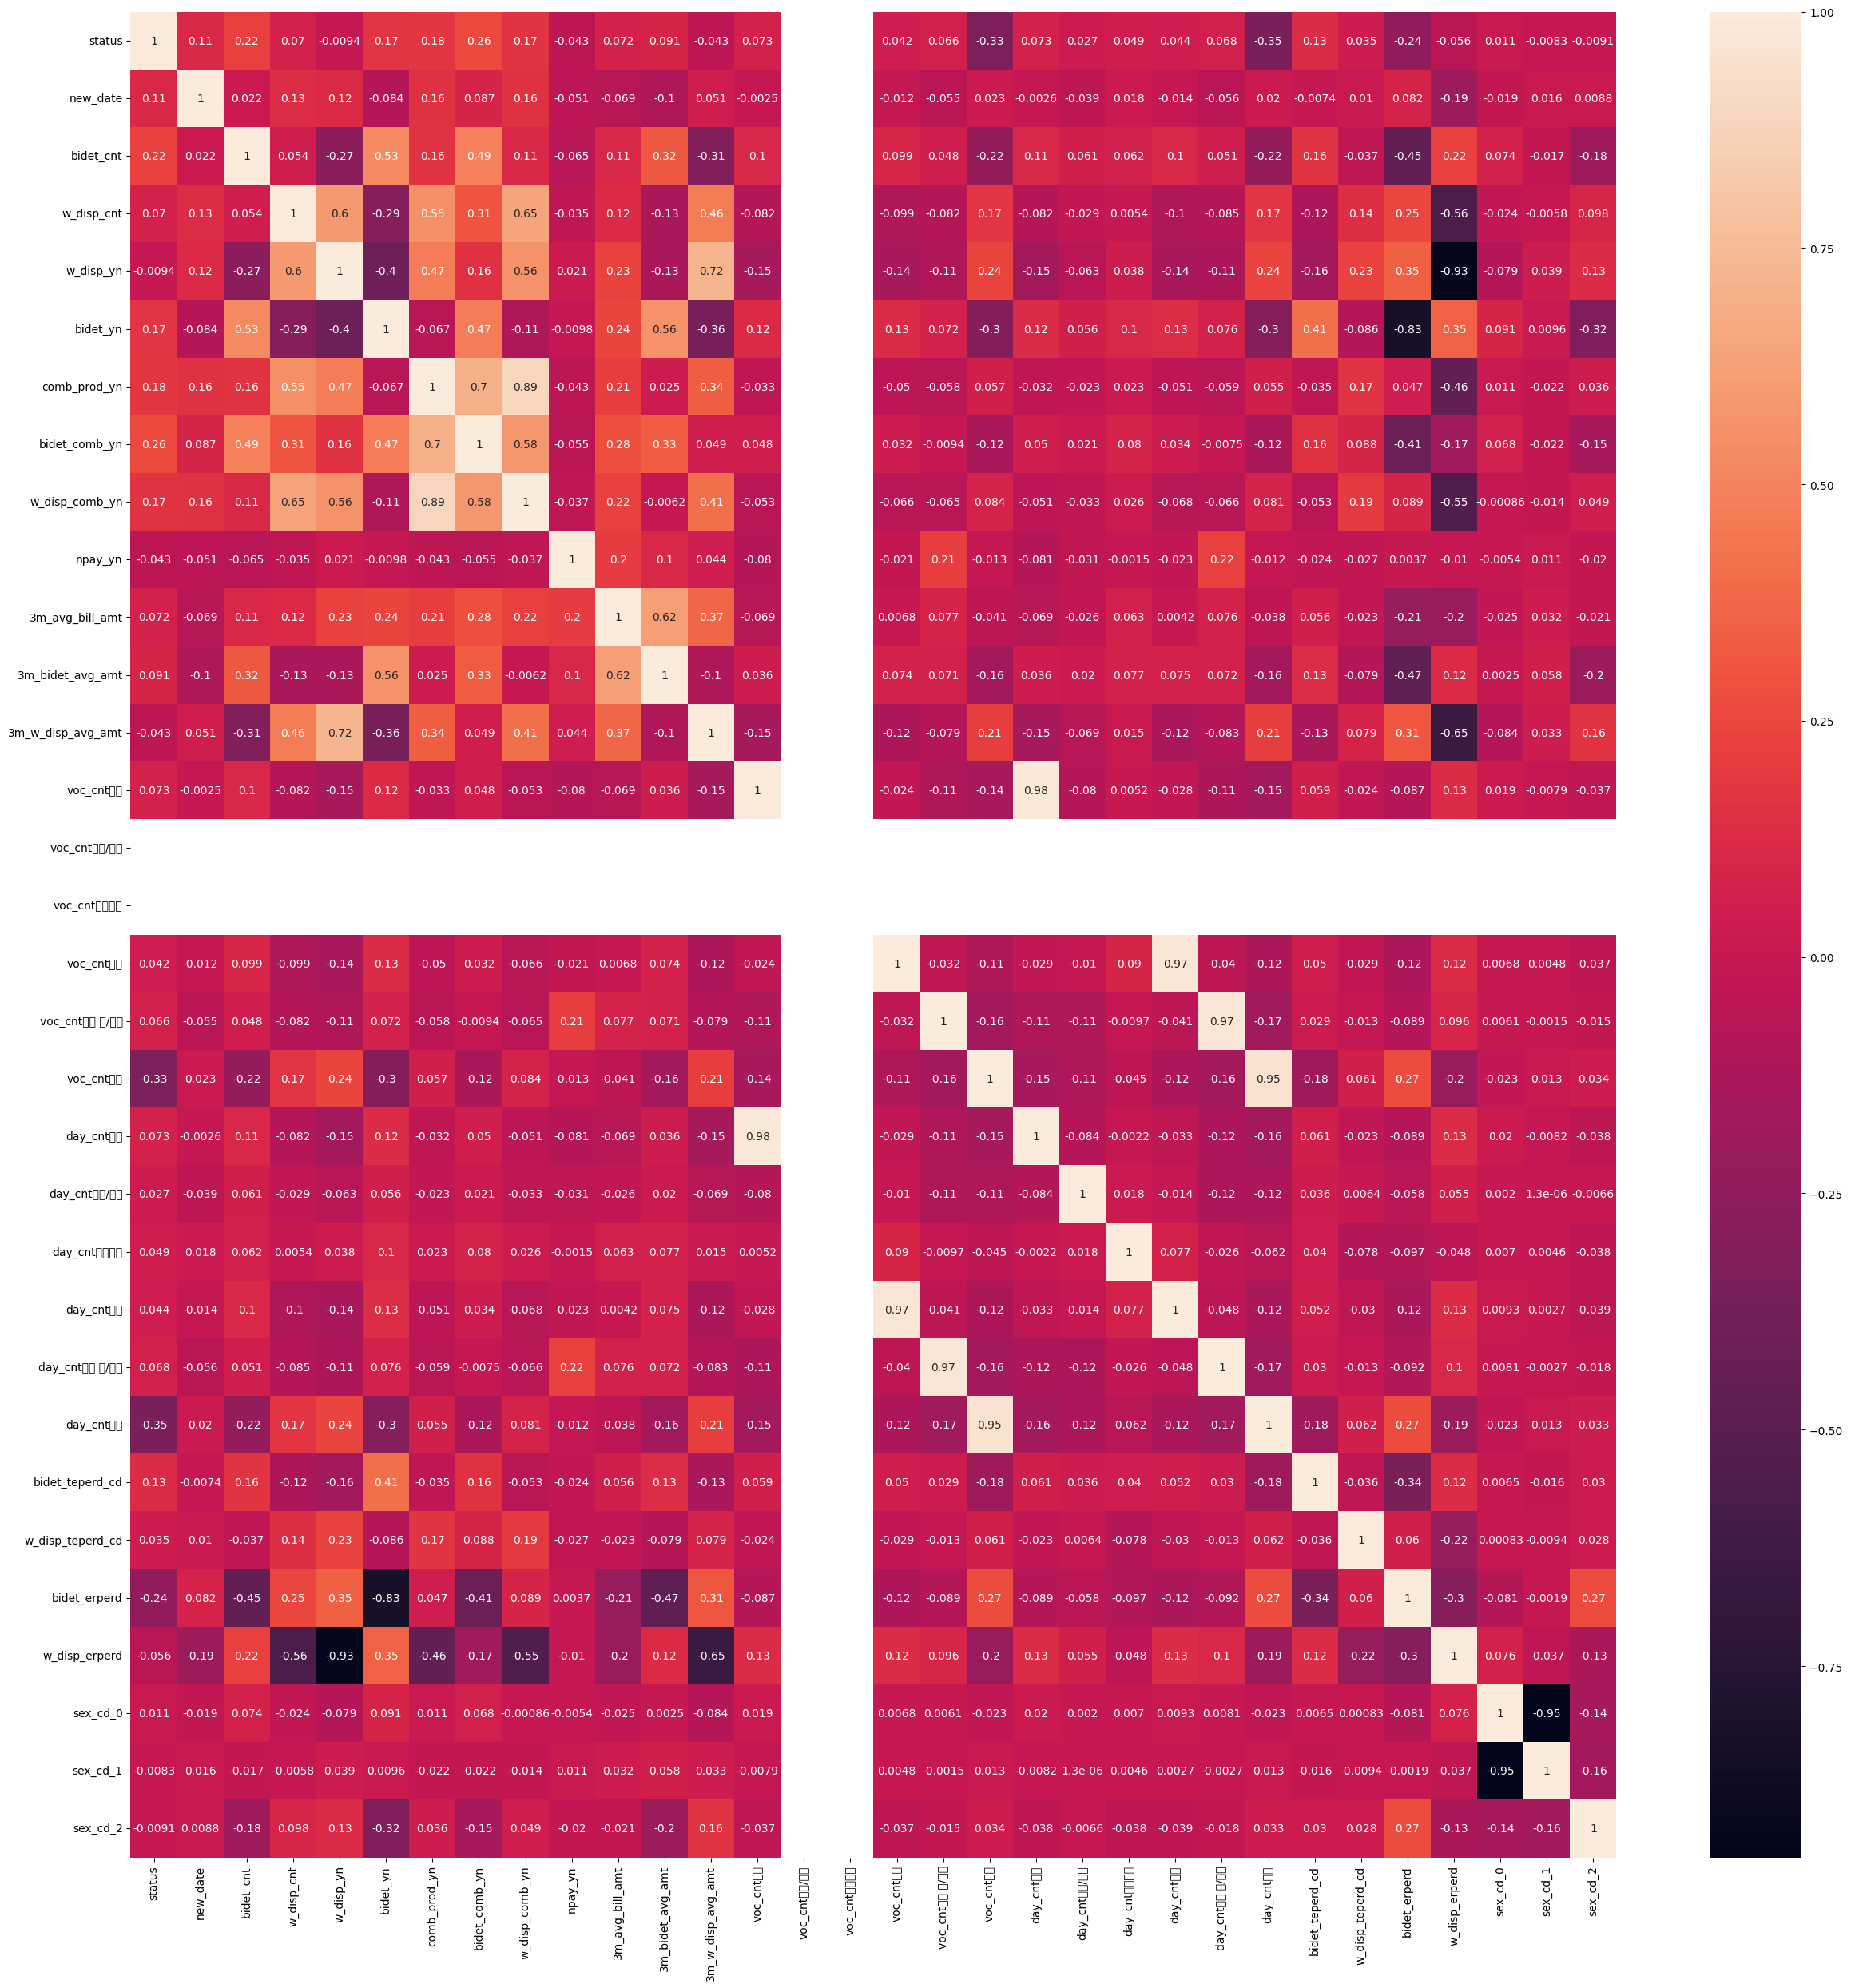

In [65]:
plt.figure(figsize=(30,30))
sns.heatmap(train_data.corr(), annot=True)

In [66]:
train_corr = train_data.corr()
mcol_linearity=[]
check = []

for idx in train_corr.index:
  check.append(idx)
  for col in train_corr.columns:
    if col not in check:

      val = train_corr.loc[idx, col]
      #print(val)
      if ((val >= 0.9) and (val < 1)) or ((-1 < val) and (val < -0.9)):
        mcol_linearity.append([idx, col])


mcol_linearity

[['w_disp_yn', 'w_disp_erperd'],
 ['voc_cnt가입', 'day_cnt가입'],
 ['voc_cnt이용', 'day_cnt이용'],
 ['voc_cnt청구 수/미납', 'day_cnt청구 수/미납'],
 ['voc_cnt해지', 'day_cnt해지'],
 ['sex_cd_0', 'sex_cd_1']]

In [67]:
#VIF 확인하기
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(train_data.values, i) for i in tqdm(range(train_data.shape[1]))]
vif['Feature'] = train_data.columns

vif = vif.sort_values(by = 'VIF_Factor', ascending=False).reset_index()

100%|██████████| 32/32 [00:06<00:00,  5.23it/s]


In [68]:
vif

,index,VIF_Factor,Feature
0,30,106.395309,sex_cd_1
1,29,94.047065,sex_cd_0
2,19,30.138093,day_cnt가입
3,13,29.980689,voc_cnt가입
4,22,19.084403,day_cnt이용
5,16,19.010744,voc_cnt이용
6,23,17.861527,day_cnt청구 수/미납
7,17,17.666513,voc_cnt청구 수/미납
8,24,10.152514,day_cnt해지
9,18,9.922746,voc_cnt해지


In [69]:
del_cols = ['sex_cd_1','voc_cnt가입','voc_cnt이용','voc_cnt청구 수/미납','voc_cnt해지']
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)

In [70]:
train_data.columns

Index(['status', 'new_date', 'bidet_cnt', 'w_disp_cnt', 'w_disp_yn',
       'bidet_yn', 'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn',
       'npay_yn', '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt변경/조회', 'voc_cnt업무협조', 'day_cnt가입', 'day_cnt변경/조회',
       'day_cnt업무협조', 'day_cnt이용', 'day_cnt청구 수/미납', 'day_cnt해지',
       'bidet_teperd_cd', 'w_disp_teperd_cd', 'bidet_erperd', 'w_disp_erperd',
       'sex_cd_0', 'sex_cd_2'],
      dtype='object')

#모델링과 평가

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('status', axis=1), train_data['status'],
                                                  random_state = 10, stratify=train_data['status'])
X_test = test_data.drop('status', axis=1)
y_test = test_data['status']

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(41232, 26) (13745, 26) (41232,) (13745,)
(4999, 26) (4999,)


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
result = pd.DataFrame([], columns = ['acc','precision','recall','F1-score'])

def result_add(model_name, pred, actual):
  acc = round(accuracy_score(actual, pred), 3)
  precision = round(precision_score(actual, pred), 3)
  recall = round(recall_score(actual, pred), 3)
  F1 = round(f1_score(actual, pred), 3)

  result.loc[model_name] = (acc, precision, recall, F1)
  result.sort_values(by='acc', inplace=True, ascending = False)

In [73]:
def result_view():
  plt.figure(figsize=(8,5))

  for idx in result.index:
    x_values = result.columns
    y_values = result.loc[idx]
    plt.plot(x_values, y_values, label = idx)

    plt.annotate(text=result.loc[idx, 'acc'], xy=(0, result.loc[idx, 'acc']), xytext=(0,result.loc[idx, 'acc']))
    plt.annotate(text=result.loc[idx, 'precision'], xy=(1, result.loc[idx, 'precision']), xytext=(1,result.loc[idx, 'precision']))
    plt.annotate(text=result.loc[idx, 'recall'], xy=(2, result.loc[idx, 'recall']), xytext=(2,result.loc[idx, 'recall']))
    plt.annotate(text=result.loc[idx, 'F1-score'], xy=(3, result.loc[idx, 'F1-score']), xytext=(3,result.loc[idx, 'F1-score']))

  plt.legend(result.index, loc=4)
  plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
result_add("Logistic Regression", pred_lr, y_test)

from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors = 10)
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)
result_add("KNN", pred_lr, y_test)

from sklearn.svm import SVC
model_svm = SVC(random_state = 21)
model_svm.fit(X_train, y_train)
pred_svm = model_svm.predict(X_test)
result_add('Support Vector Machine', pred_svm, y_test)

In [75]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(min_samples_split=100, max_depth = 10, max_features = 10)
model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)
result_add('Decision Tree Classifier', pred_dt, y_test)

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(min_samples_split=100, max_depth = 10, max_features = 10, n_estimators = 100, n_jobs = -1)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
result_add('Random Forest Classifier', pred_dt, y_test)

In [76]:
import xgboost as xgb

early_stop = xgb.callback.EarlyStopping(
    rounds=2, metric_name='logloss', data_name='validation_0', save_best=True
)
model_xgb = xgb.XGBClassifier(learning_rate = 0.1, n_jobs=-1, n_estimators=500, random_state=21, callback=[early_stop])

model_xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose=True)

pred_xgb = model_xgb.predict(X_test)
result_add('XGBoost', pred_xgb, y_test)

[0]	validation_0-logloss:0.65434
[1]	validation_0-logloss:0.63325
[2]	validation_0-logloss:0.61564
[3]	validation_0-logloss:0.60071
[4]	validation_0-logloss:0.58861
[5]	validation_0-logloss:0.57799
[6]	validation_0-logloss:0.56877
[7]	validation_0-logloss:0.56063
[8]	validation_0-logloss:0.55386
[9]	validation_0-logloss:0.54761
[10]	validation_0-logloss:0.54248
[11]	validation_0-logloss:0.53792
[12]	validation_0-logloss:0.53407
[13]	validation_0-logloss:0.53037
[14]	validation_0-logloss:0.52739
[15]	validation_0-logloss:0.52471
[16]	validation_0-logloss:0.52203
[17]	validation_0-logloss:0.51986
[18]	validation_0-logloss:0.51759
[19]	validation_0-logloss:0.51576
[20]	validation_0-logloss:0.51417
[21]	validation_0-logloss:0.51286
[22]	validation_0-logloss:0.51144
[23]	validation_0-logloss:0.51030
[24]	validation_0-logloss:0.50895
[25]	validation_0-logloss:0.50802
[26]	validation_0-logloss:0.50699
[27]	validation_0-logloss:0.50595
[28]	validation_0-logloss:0.50529
[29]	validation_0-loglos

In [77]:
from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier(learning_rate = 0.03, iterations=2000, random_state=21)
train_dataset = Pool(data = X_train, label = y_train)
eval_dataset = Pool(data = X_val, label = y_val)
cat.fit(train_dataset, eval_set = eval_dataset, early_stopping_rounds=30)

pred_cat = cat.predict(X_test)
result_add('Cat Boost', pred_cat, y_test)

0:	learn: 0.6840288	test: 0.6837243	best: 0.6837243 (0)	total: 59.1ms	remaining: 1m 58s
1:	learn: 0.6752366	test: 0.6748036	best: 0.6748036 (1)	total: 69.8ms	remaining: 1m 9s
2:	learn: 0.6667988	test: 0.6661149	best: 0.6661149 (2)	total: 80.5ms	remaining: 53.6s
3:	learn: 0.6594203	test: 0.6585023	best: 0.6585023 (3)	total: 91.5ms	remaining: 45.7s
4:	learn: 0.6518471	test: 0.6507611	best: 0.6507611 (4)	total: 106ms	remaining: 42.1s
5:	learn: 0.6451818	test: 0.6439133	best: 0.6439133 (5)	total: 116ms	remaining: 38.7s
6:	learn: 0.6392072	test: 0.6377623	best: 0.6377623 (6)	total: 127ms	remaining: 36.2s
7:	learn: 0.6331887	test: 0.6315326	best: 0.6315326 (7)	total: 138ms	remaining: 34.4s
8:	learn: 0.6274640	test: 0.6256995	best: 0.6256995 (8)	total: 149ms	remaining: 33s
9:	learn: 0.6225981	test: 0.6206589	best: 0.6206589 (9)	total: 160ms	remaining: 31.9s
10:	learn: 0.6175373	test: 0.6154501	best: 0.6154501 (10)	total: 171ms	remaining: 30.9s
11:	learn: 0.6130796	test: 0.6108753	best: 0.6108

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X_train.shape, y_train.shape

((41232, 26), (41232,))

In [79]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
dnn = Sequential()
dnn.add(Dense(8, activation = 'relu', input_shape = (26, ), kernel_initializer = initializer))
dnn.add(Dropout(0.2))
dnn.add(Dense(2, activation = 'relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation = 'sigmoid'))
dnn.summary()

dnn.compile(optimizer='adam', loss='binary_crossentropy',metrics =['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237 (948.00 B)

 Trainable params: 237 (948.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor = 'val_loss', mode='min',verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', monitor = 'val_loss', mode='min', verbose=1, save_best_only=True)
dnn.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), verbose=1, callbacks = [early_stop, check_point])

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5866 - loss: 0.6803
Epoch 1: val_loss improved from inf to 0.63923, saving model to best_model.h5


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5866 - loss: 0.6803 - val_accuracy: 0.6575 - val_loss: 0.6392


In [81]:
pred_dnn = dnn.predict(X_test)
pred_dnn = (pred_dnn>0.5).astype('int32')
result_add('DNN', pred_dnn.reshape(1,-1)[0], y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


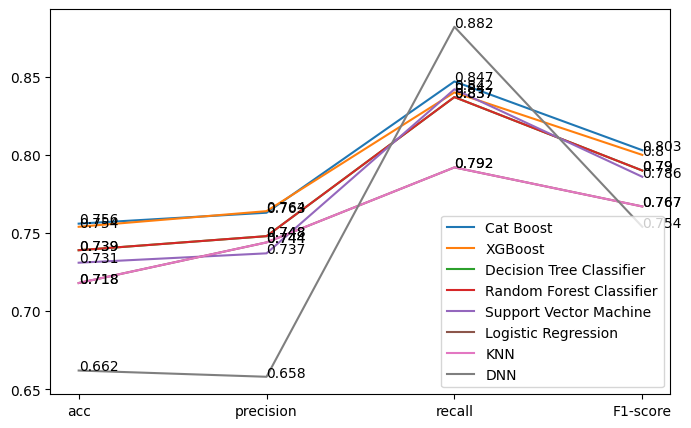

In [82]:
result_view()

In [83]:
result

,acc,precision,recall,F1-score
Cat Boost,0.756,0.763,0.847,0.803
XGBoost,0.754,0.764,0.840,0.800
Decision Tree Classifier,0.739,0.748,0.837,0.790
Random Forest Classifier,0.739,0.748,0.837,0.790
Support Vector Machine,0.731,0.737,0.842,0.786
Logistic Regression,0.718,0.744,0.792,0.767
KNN,0.718,0.744,0.792,0.767
DNN,0.662,0.658,0.882,0.754


#catboost, dnn 혼동 행렬

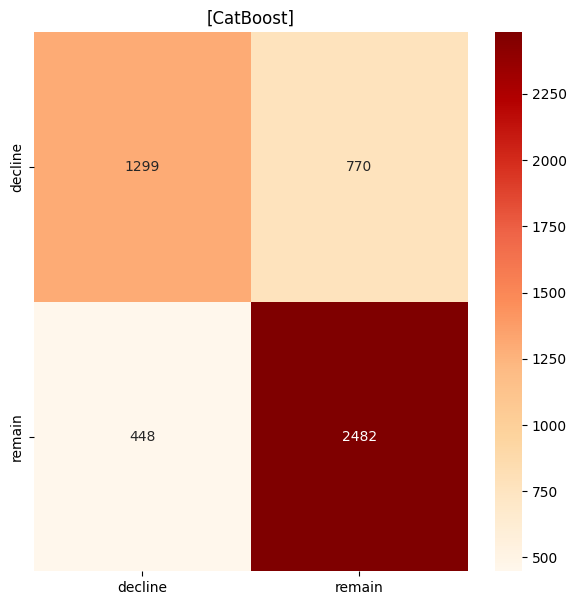

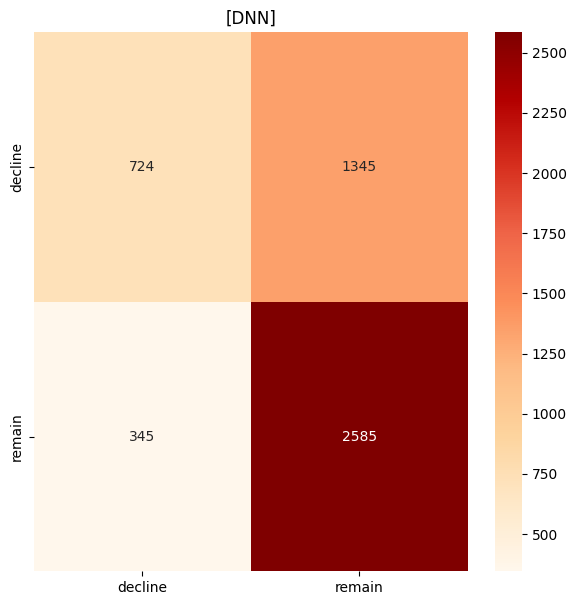

(None, None)

In [113]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(labels, y_true, y_pred, title):
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
              xticklabels=labels, yticklabels=labels,
              cmap=plt.cm.OrRd)
  plt.title(title)
  plt.show()

labels = ['decline','remain']
show_confusion_matrix(labels, y_test, pred_cat, '[CatBoost]'), show_confusion_matrix(labels, y_test, pred_dnn, '[DNN]')

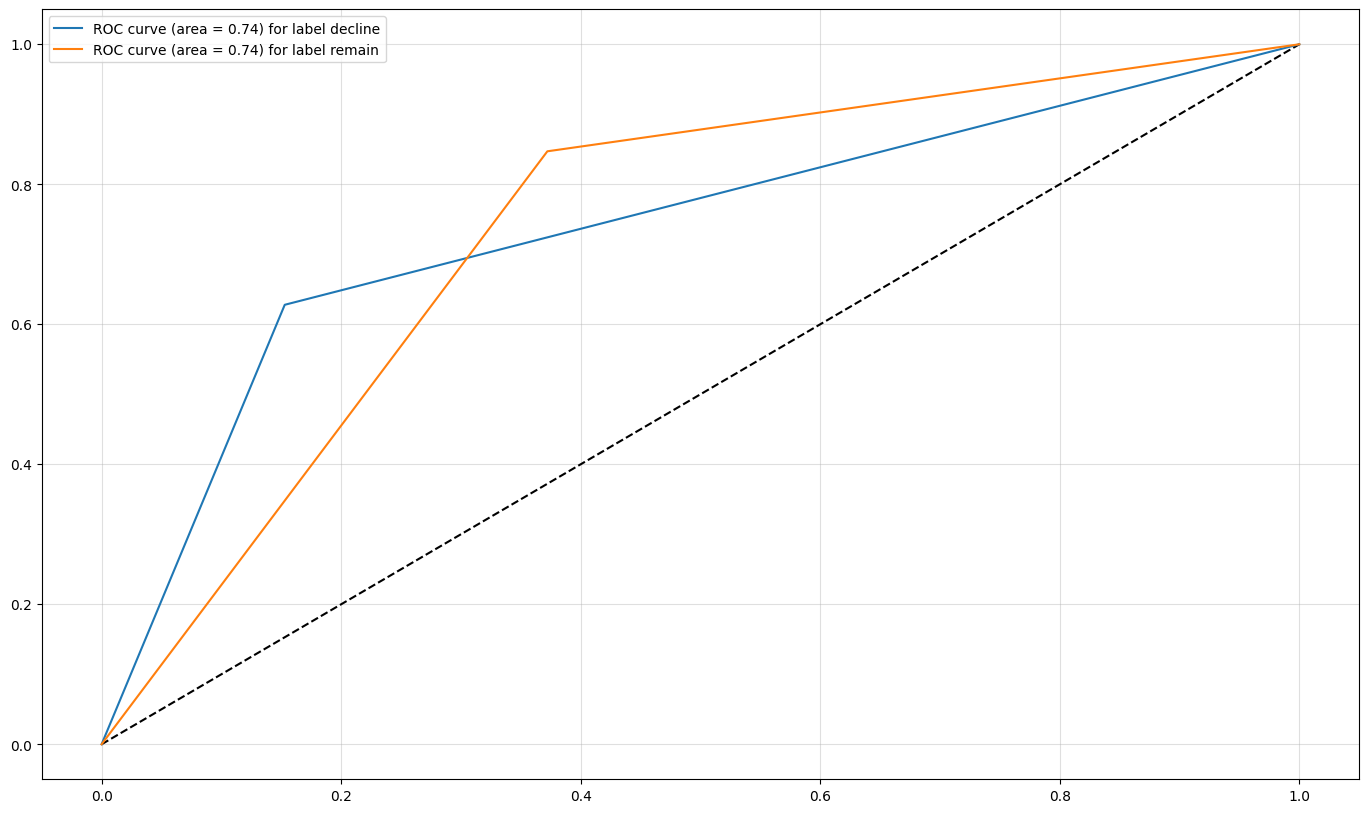

In [150]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_pred, y_true, y_label):

  fpr, tpr, roc_auc = dict(), dict(), dict()

  y_test_dummies = pd.get_dummies(y_true, drop_first=False).values

  for i in range(len(y_label)):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
    roc_auc[i]= auc(fpr[i], tpr[i])


  fig, ax = plt.subplots(figsize=(17,10))
  ax.plot([0,1],[0,1], 'k--')

  for i in range(len(y_label)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' %(roc_auc[i], y_label[i]))
  ax.grid(alpha=0.4)
  ax.legend()
  plt.show()

labels = ['decline','remain']
plot_multiclass_roc(pd.get_dummies(pred_cat).to_numpy(), y_test, labels)

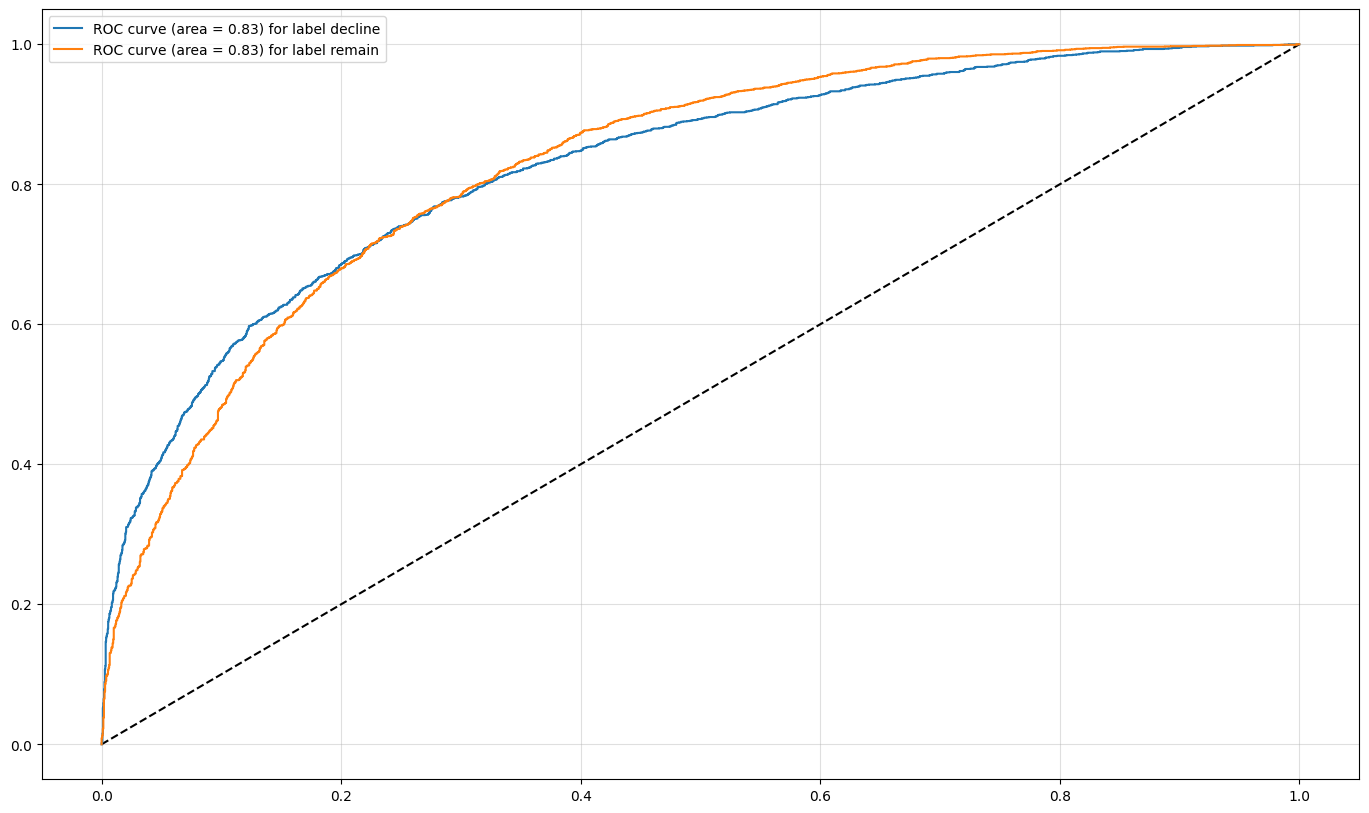

In [151]:
pred_cat_proba = cat.predict_proba(X_test)
plot_multiclass_roc(pred_cat_proba, y_test, labels)

In [155]:
pred_cat_proba[:,0], pred_cat_proba[:,1]

(array([0.07898747, 0.35476642, 0.64217305, ..., 0.51925941, 0.79920138,
        0.30035447]),
 array([0.92101253, 0.64523358, 0.35782695, ..., 0.48074059, 0.20079862,
        0.69964553]))